In [ ]:
#some common imports
import pandas as pd
import numpy as np
import warnings
import math
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from tqdm import tqdm
from scipy.stats import iqr
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import hstack
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from prettytable import PrettyTable
warnings.filterwarnings("ignore")

# Problem Description

An education company named X Education sells online courses to industry professionals. On any given day, many professionals who are interested in the courses land on their website and browse for courses.
The company markets its courses on several websites and search engines like Google. Once people land on the website, they might browse the courses or fill up a form for the course or watch some videos. When these people fill up a form providing their email address or phone number, they are classified to be a lead. Additionally, the company also gets leads through referrals. Once these leads are acquired, employees from the sales team start making calls, writing emails, etc. Through this process, some of the leads get converted while most do not. The typical lead conversion rate at X Education is around 30%.
There are a lot of leads generated in the initial stage, but only a few of them come out as paying customers. In the middle stage, the company nurtures the potential leads (i.e. educating the leads about the product, constantly communicating, etc. ) in order to get a higher lead conversion.
X Education has appointed you to help them select the most promising leads for follow-up, i.e. the leads that are most likely to convert into paying customers.

**Task :** Build a model to assign a score between 0 and 100 to leads which can be used by the company to target potential leads.

#Data Details

We have 37 columns, details of these are:
1. Prospect ID : A unique ID with which the customer is identified.
2. Lead Number : A lead number assigned to each lead procured.
3. Lead Origin : The origin identifier with which the customer was identified to be a lead. Includes API, Landing Page Submission, etc.
4. Lead Source : The source of the lead. Includes Google, Organic Search, Olark Chat, etc.
5. Do Not Email : An indicator variable selected by the customer wherein they select whether of not they want to be emailed about the course or not.
6. Do Not Call : An indicator variable selected by the customer wherein they select whether of not they want to be called about the course or not.
7. Converted : The target variable. Indicates whether a lead has been successfully converted or not.
8. TotalVisits : The total number of visits made by the customer on the website.
9. Total Time Spent on Website : The total time spent by the customer on the website.
10. Page Views Per Visit : Average number of pages on the website viewed during the visits.
11. Last Activity : Last activity performed by the customer. Includes Email Opened, Olark Chat Conversation, etc.
12. Country : The country of the customer.
13. Specialization : The industry domain in which the customer worked before. Includes the level 'Select Specialization' which means the customer had not selected this option while filling the form.
14. How did you hear about X Education : The source from which the customer heard about X Education.
15. What is your current occupation : Indicates whether the customer is a student, umemployed or employed.
16. What matters most to you in choosing this course : An option selected by the customer indicating what is their main motto behind doing this course.
17. Fields suggesting that customer have seen ad in any of the listed fields, fields are: Search, Magazine, Newspaper Article, X Education Forums, Newspaper, Digital Advertisement
18. Through Recommendations : Indicates whether the customer came in through recommendations.
19. Receive More Updates About Our Courses : Indicates whether the customer chose to receive more updates about the courses.
20. Tags: Tags assigned to customers indicating the current status of the lead.
21. Lead Quality : Indicates the quality of lead based on the data and intuition the the employee who has been assigned to the lead.
22. Update me on Supply Chain Content : Indicates whether the customer wants updates on the Supply Chain Content.
23. Get updates on DM Content : Indicates whether the customer wants updates on the DM Content.
24. Lead Profile : A lead level assigned to each customer based on their profile.
25. City : The city of customer
26. An index and score assigned to each customer based on their activity and their profile, these index types are: Asymmetrique Activity Index, Asymmetrique Profile Index, Asymmetrique Activity Score, Asymmetrique Profile Score.
27. I agree to pay the amount through cheque : Indicates whether the customer has agreed to pay the amount through cheque or not.
28. a free copy of Mastering The Interview : Indicates whether the customer wants a free copy of 'Mastering the Interview' or not.
29. Last Notable Activity : The last notable acitivity performed by the student.

Let's start by loading data....

In [ ]:
#Loading Data
data = pd.read_csv('/content/drive/MyDrive/cs/Leads.csv')

In [ ]:
data.head()

,Prospect ID,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Country,Specialization,How did you hear about X Education,What is your current occupation,What matters most to you in choosing a course,Search,Magazine,Newspaper Article,X Education Forums,Newspaper,Digital Advertisement,Through Recommendations,Receive More Updates About Our Courses,Tags,Lead Quality,Update me on Supply Chain Content,Get updates on DM Content,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,660737,API,Olark Chat,No,No,0,0.0,0,0.0,Page Visited on Website,NaN,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Interested in other courses,Low in Relevance,No,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Modified
1,2a272436-5132-4136-86fa-dcc88c88f482,660728,API,Organic Search,No,No,0,5.0,674,2.5,Email Opened,India,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Ringing,NaN,No,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Email Opened
2,8cc8c611-a219-4f35-ad23-fdfd2656bd8a,660727,Landing Page Submission,Direct Traffic,No,No,1,2.0,1532,2.0,Email Opened,India,Business Administration,Select,Student,Better Career Prospects,No,No,No,No,No,No,No,No,Will revert after reading the email,Might be,No,No,Potential Lead,Mumbai,02.Medium,01.High,14.0,20.0,No,Yes,Email Opened
3,0cc2df48-7cf4-4e39-9de9-19797f9b38cc,660719,Landing Page Submission,Direct Traffic,No,No,0,1.0,305,1.0,Unreachable,India,Media and Advertising,Word Of Mouth,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Ringing,Not Sure,No,No,Select,Mumbai,02.Medium,01.High,13.0,17.0,No,No,Modified
4,3256f628-e534-4826-9d63-4a8b88782852,660681,Landing Page Submission,Google,No,No,1,2.0,1428,1.0,Converted to Lead,India,Select,Other,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Will revert after reading the email,Might be,No,No,Select,Mumbai,02.Medium,01.High,15.0,18.0,No,No,Modified


In [ ]:
print('Given raw data is having {} rows and {} columns'.format(data.shape[0], data.shape[1]))

Given raw data is having 9240 rows and 37 columns


In [ ]:
#Just doing an info on our data.....
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 37 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Prospect ID                                    9240 non-null   object 
 1   Lead Number                                    9240 non-null   int64  
 2   Lead Origin                                    9240 non-null   object 
 3   Lead Source                                    9204 non-null   object 
 4   Do Not Email                                   9240 non-null   object 
 5   Do Not Call                                    9240 non-null   object 
 6   Converted                                      9240 non-null   int64  
 7   TotalVisits                                    9103 non-null   float64
 8   Total Time Spent on Website                    9240 non-null   int64  
 9   Page Views Per Visit                           9103 

Most of the fields that we have are categorical, and we do have some null values to deal with.... let us hold these thoughts for EDA... Let us first try to convert this problem into a ML problem.....

#Converting business problem into a ML problem

While converting this into a ML problem, we have to keep in mind the task that we have, our model should assign a score of 0 to 100 to leads. Now to convert this into a supervised learning problem we need some ground truth, which is the columns Converted.

What we will do in this case is, we will make our model to generate probabilities and those probabilities will be the final score that we will give for each of our data point on test data.

Since we are generating probabilities, we need to understand the fact that apart from Logistic Regression(that too with balanced data, with unbalanced even this does not give true probab distribution) all other models probability outputs are not the actual probability distribution. So, to genearte correct numbers we need to calibrate our models, so that the generated probability distribution matches the actual probability distribution.

**Choise of KPI**

Since we are trying to generate the probabilities, we will try to minimize **log loss** as our **primary KPI** as it penalizes a lot for small deviation and it works well in cases when we are dealing with probability.

Log loss does have an interpretability issue, so just to make some sense from our data we'll also be creating confusion matrix along with precision, recall matrix.


Now we have most of the information needed to start our work..... Let us Explore our data.....

#EDA

In [ ]:
data.head(2)

,Prospect ID,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Country,Specialization,How did you hear about X Education,What is your current occupation,What matters most to you in choosing a course,Search,Magazine,Newspaper Article,X Education Forums,Newspaper,Digital Advertisement,Through Recommendations,Receive More Updates About Our Courses,Tags,Lead Quality,Update me on Supply Chain Content,Get updates on DM Content,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,660737,API,Olark Chat,No,No,0,0.0,0,0.0,Page Visited on Website,NaN,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Interested in other courses,Low in Relevance,No,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Modified
1,2a272436-5132-4136-86fa-dcc88c88f482,660728,API,Organic Search,No,No,0,5.0,674,2.5,Email Opened,India,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Ringing,NaN,No,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Email Opened


**Let us get some insight about our target variable**

In [ ]:
#Simple shuffle of columns
data = data[list(data.columns[0:6]) + list(data.columns[7:]) + ['Converted']]

In [ ]:
print(data['Converted'].value_counts())
print(data['Converted'].value_counts(normalize = True))

0    5679
1    3561
Name: Converted, dtype: int64
0    0.61461
1    0.38539
Name: Converted, dtype: float64


Data is not highly imbalanced....

In [ ]:
print("Number of unique values for feature:")
data.nunique()

Number of unique values for feature:


Prospect ID                                      9240
Lead Number                                      9240
Lead Origin                                         5
Lead Source                                        21
Do Not Email                                        2
Do Not Call                                         2
TotalVisits                                        41
Total Time Spent on Website                      1731
Page Views Per Visit                              114
Last Activity                                      17
Country                                            38
Specialization                                     19
How did you hear about X Education                 10
What is your current occupation                     6
What matters most to you in choosing a course       3
Search                                              2
Magazine                                            1
Newspaper Article                                   2
X Education Forums          

 We do need a data cleaning exercise....

<h1> Data Cleaning </h1>

**Before starting the actual analysis, let us start with simple data cleaning exercise to drop unwanted columns(if any) from our data**

<h2> Looking for columns with unique values in them </h2>

In [ ]:
print('{} columns have just one value in them'.format(len(data.loc[:, data.nunique() == 1].columns)))
print('Name of these columns are: {}'.format(list(data.loc[:, data.nunique() == 1].columns)))

5 columns have just one value in them
Name of these columns are: ['Magazine', 'Receive More Updates About Our Courses', 'Update me on Supply Chain Content', 'Get updates on DM Content', 'I agree to pay the amount through cheque']


In [ ]:
print('Values present in each of these columns are: ')
for col in data.loc[:, data.nunique() == 1]:
  print('{} : {}'.format(col, data[col].unique()))

Values present in each of these columns are: 
Magazine : ['No']
Receive More Updates About Our Courses : ['No']
Update me on Supply Chain Content : ['No']
Get updates on DM Content : ['No']
I agree to pay the amount through cheque : ['No']


In [ ]:
data[list(data.loc[:, data.nunique() == 1].columns)].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 5 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   Magazine                                  9240 non-null   object
 1   Receive More Updates About Our Courses    9240 non-null   object
 2   Update me on Supply Chain Content         9240 non-null   object
 3   Get updates on DM Content                 9240 non-null   object
 4   I agree to pay the amount through cheque  9240 non-null   object
dtypes: object(5)
memory usage: 361.1+ KB


**All these columns have just one value and will not be informative if we add them for our modeling purpose, hence as part of our cleaning exercise we are dropping these columns**

In [ ]:
data = data.drop(list(data.loc[:, data.nunique() == 1].columns), axis = 1)

In [ ]:
print('After dropping these columns we are left out with {} columns'.format(data.shape[1]))

After dropping these columns we are left out with 32 columns


<h2> Looking for columns having the same number of values as number of data points </h2>

In [ ]:
print('We have {} columns with unique values as number of data points and these are: {}'.format(len(data.loc[:, data.nunique() == data.shape[0]].columns), list(data.loc[:, data.nunique() == data.shape[0]].columns)))

We have 2 columns with unique values as number of data points and these are: ['Prospect ID', 'Lead Number']


**As per the data definition, these are the unique identification given to each customer, at the time of working on the solution we can ignore these, they will be helpful during the production phase and after model prediction can be used by sales team of X Education to work on leads with high score... Dropping these for now as they are not significant for modeling purpose....**

In [ ]:
data = data.drop(list(data.loc[:, data.nunique() == data.shape[0]].columns), axis = 1)

In [ ]:
print('After dropping these columns we are left out with {} columns'.format(data.shape[1]))

After dropping these columns we are left out with 30 columns


<h2> Looking for pair of columns with same values per row </h2>

In [ ]:
[(col1, col2) for col1, col2 in combinations(data, 2) if data[col1].equals(data[col2])]

[]

**No pair of columns have same values.... Good....**

<h2> Checking for quasi constant columns </h2>

In [ ]:
quasi_lst = []
for col in data.columns:
  if data[col].value_counts(normalize = True).sort_values().iloc[-1] >= .99:
    quasi_lst.append(col)

In [ ]:
quasi_lst

['Do Not Call',
 'What matters most to you in choosing a course',
 'Search',
 'Newspaper Article',
 'X Education Forums',
 'Newspaper',
 'Digital Advertisement',
 'Through Recommendations']

In [ ]:
data[quasi_lst].head()

,Do Not Call,What matters most to you in choosing a course,Search,Newspaper Article,X Education Forums,Newspaper,Digital Advertisement,Through Recommendations
0,No,Better Career Prospects,No,No,No,No,No,No
1,No,Better Career Prospects,No,No,No,No,No,No
2,No,Better Career Prospects,No,No,No,No,No,No
3,No,Better Career Prospects,No,No,No,No,No,No
4,No,Better Career Prospects,No,No,No,No,No,No


In [ ]:
for col in quasi_lst:
  print('col : {}, no_unique_values : {}, values : {}'.format(col, data[col].nunique(), list(data[col].unique())))

col : Do Not Call, no_unique_values : 2, values : ['No', 'Yes']
col : What matters most to you in choosing a course, no_unique_values : 3, values : ['Better Career Prospects', nan, 'Flexibility & Convenience', 'Other']
col : Search, no_unique_values : 2, values : ['No', 'Yes']
col : Newspaper Article, no_unique_values : 2, values : ['No', 'Yes']
col : X Education Forums, no_unique_values : 2, values : ['No', 'Yes']
col : Newspaper, no_unique_values : 2, values : ['No', 'Yes']
col : Digital Advertisement, no_unique_values : 2, values : ['No', 'Yes']
col : Through Recommendations, no_unique_values : 2, values : ['No', 'Yes']


Quasi list variables are the one with most of the values belonging to one particular category, in this case we have chosen our quasi constant threshold to be 99%, so a variable with more than 99% unique value will be considered as quasi constant.....

Now, we see that the ad related items are coming out to te quasi constant, that means we don't have many users who have seen ad on these 5 platforms. Let us do one thing, create a binary feature from these and see if that makes any sense, so the new feature will be seen_ad, it will have a value of 1 if it has a yes in any of these 5 columns, 0 otherwise.....

In [ ]:
seen_ad_lst = []
for index_num in range(data.shape[0]):
  if data.iloc[index_num]['Search'] == 'Yes' or data.iloc[index_num]['Newspaper Article'] == 'Yes' or data.iloc[index_num]['X Education Forums'] == 'Yes' or data.iloc[index_num]['Newspaper'] == 'Yes' or data.iloc[index_num]['Digital Advertisement'] == 'Yes' or data.iloc[index_num]['Through Recommendations'] == 'Yes':
    seen_ad_lst.append(1)
  else:
    seen_ad_lst.append(0)

In [ ]:
data['seen_ad'] = seen_ad_lst

In [ ]:
#verifying if it worked....
data[data['Search'] == 'Yes']['seen_ad']

2307    1
2511    1
2821    1
2897    1
3203    1
3844    1
5193    1
5568    1
7195    1
7377    1
8385    1
8387    1
8541    1
8848    1
Name: seen_ad, dtype: int64

In [ ]:
data[data['Through Recommendations'] == 'Yes']['seen_ad']

788     1
2821    1
3829    1
5193    1
6699    1
8521    1
8541    1
Name: seen_ad, dtype: int64

In [ ]:
#Let us now drop the 6 variables using which we created our new column.....
data = data.drop(quasi_lst[2:], axis = 1)

In [ ]:
#Let us now check the newly created columns, before keeping it, we need to see if it does make sense to have it in our feature list....
data['seen_ad'].value_counts(normalize = True)

0    0.997511
1    0.002489
Name: seen_ad, dtype: float64

This is almost close to null for class 1.....

In [ ]:
data[data['seen_ad'] == 1]['Converted'].value_counts(normalize = True)

0    0.521739
1    0.478261
Name: Converted, dtype: float64

Having this won't add much value, hence dropping this newly created feature as well...

In [ ]:
data = data.drop('seen_ad', axis = 1)

In [ ]:
print('After dropping these columns we are left out with {} columns'.format(data.shape[1]))

After dropping these columns we are left out with 24 columns


We have 2 more columns in our list to check as if they were also part of our quasi list....

In [ ]:
data[quasi_lst[0]].value_counts()

No     9238
Yes       2
Name: Do Not Call, dtype: int64

In [ ]:
print('{} again is having only 2 values that are different, rest of the values are same, we are going to drop this as well from our data'.format(quasi_lst[0]))

Do Not Call again is having only 2 values that are different, rest of the values are same, we are going to drop this as well from our data


In [ ]:
data = data.drop(quasi_lst[0], axis = 1)

In [ ]:
print('After dropping these columns we are left out with {} columns'.format(data.shape[1]))

After dropping these columns we are left out with 23 columns


In [ ]:
print('{} had some null values as well, will check this in some time'.format(quasi_lst[1]))

What matters most to you in choosing a course had some null values as well, will check this in some time


**This completes our basic data cleaning exercise, based on our observation of data, few of the columns were dropped directly as keeping them was not making sense. So, after data cleaning we are left with some 23 columns....**

**Important Points**

1. Initial data cleaning exercise was generic, based on some initial observations that will be same for test data(unseen).
2. Now if we want to treat missing values we need to make sure that we are doing it only on train data as test data is unseen data. Also, whatever treatment we do for missing values in our train data, it should be reflected on the test data depending upon the query point or the batch of query point based on our analysis on training data.
3. If we will treat missing value before spliting the data. We will introduce the problem of **data leakage** and our model will not generalize better, hence splitting the data into train, test, cv.

<h1> Posing our problem into a ML problem </h1>

<h2> Test, Train and cv split </h2>

In [ ]:
y_true = data['Converted'].values
X_train, test_df, y_train, y_test = train_test_split(data, y_true, stratify=y_true, test_size=0.2)
train_df, cv_df, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.15)

In [ ]:
print('Number of data points in train data:', train_df.shape[0])
print('Number of data points in test data:', test_df.shape[0])
print('Number of data points in cross validation data:', cv_df.shape[0])

Number of data points in train data: 6283
Number of data points in test data: 1848
Number of data points in cross validation data: 1109


**Since we have done a split, let us just check the distribution of Y_i's in train, test and cv**

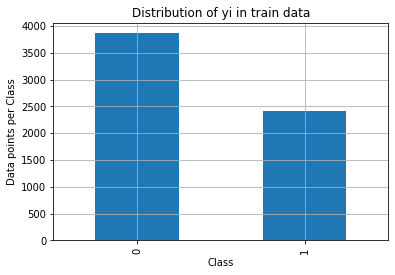

Number of data points in class 0 : 3861 (61.452 %)
Number of data points in class 1 : 2422 (38.548 %)
--------------------------------------------------------------------------------


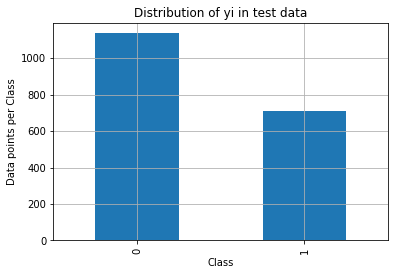

Number of data points in class 0 : 1136 (61.472 %)
Number of data points in class 1 : 712 (38.528 %)
--------------------------------------------------------------------------------


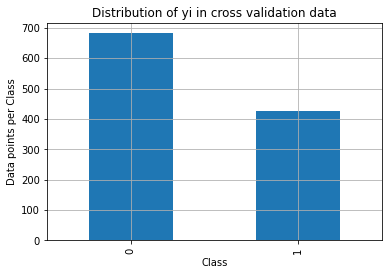

Number of data points in class 0 : 682 (61.497 %)
Number of data points in class 1 : 427 (38.503 %)


In [ ]:
train_class_distribution = train_df['Converted'].value_counts().sort_index()
test_class_distribution = test_df['Converted'].value_counts().sort_index()
cv_class_distribution = cv_df['Converted'].value_counts().sort_index()

train_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in train data')
plt.grid()
plt.show()

for i in range(train_class_distribution.shape[0]):
  print('Number of data points in class {} : {} ({} %)'.format(i, train_class_distribution.values[i], np.round((train_class_distribution.values[i]/train_df.shape[0]*100), 3)))

print('-'*80)
test_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in test data')
plt.grid()
plt.show()

for i in range(test_class_distribution.shape[0]):
  print('Number of data points in class {} : {} ({} %)'.format(i, test_class_distribution.values[i], np.round((test_class_distribution.values[i]/test_df.shape[0]*100), 3)))


print('-'*80)
cv_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in cross validation data')
plt.grid()
plt.show()

for i in range(cv_class_distribution.shape[0]):
  print('Number of data points in class {} : {} ({} %)'.format(i, cv_class_distribution.values[i], np.round((cv_class_distribution.values[i]/cv_df.shape[0]*100), 3)))

**Above plots indicate that the class distribution is even across all the set that we have.....**

<h2> Null Value Check </h2>

In [ ]:
train_df.isnull().mean()

Lead Origin                                      0.000000
Lead Source                                      0.003183
Do Not Email                                     0.000000
TotalVisits                                      0.013051
Total Time Spent on Website                      0.000000
Page Views Per Visit                             0.013051
Last Activity                                    0.010027
Country                                          0.260544
Specialization                                   0.154067
How did you hear about X Education               0.239535
What is your current occupation                  0.288716
What matters most to you in choosing a course    0.290944
Tags                                             0.358109
Lead Quality                                     0.515677
Lead Profile                                     0.290944
City                                             0.151997
Asymmetrique Activity Index                      0.453446
Asymmetrique P

In [ ]:
print('{} columns have missing values & these are: {}'.format(len(train_df.columns[train_df.isnull().mean() > 0]), list(train_df.columns[train_df.isnull().mean() > 0])))

17 columns have missing values & these are: ['Lead Source', 'TotalVisits', 'Page Views Per Visit', 'Last Activity', 'Country', 'Specialization', 'How did you hear about X Education', 'What is your current occupation', 'What matters most to you in choosing a course', 'Tags', 'Lead Quality', 'Lead Profile', 'City', 'Asymmetrique Activity Index', 'Asymmetrique Profile Index', 'Asymmetrique Activity Score', 'Asymmetrique Profile Score']


**Theoretically 25-30% is the max limit for missing values, in our case we have some 17 columns with missing fields, let us start by first looking into missing columns having more than 25% missing values**

In [ ]:
print('{} columns have more than 25% missing values & they are: {}'.format(len(train_df.columns[train_df.isnull().mean() > .25]), list(train_df.columns[train_df.isnull().mean() > .25])))

10 columns have more than 25% missing values & they are: ['Country', 'What is your current occupation', 'What matters most to you in choosing a course', 'Tags', 'Lead Quality', 'Lead Profile', 'Asymmetrique Activity Index', 'Asymmetrique Profile Index', 'Asymmetrique Activity Score', 'Asymmetrique Profile Score']


Let us try to see if we can do some imputation for the columns with less % of missing values and we'll decide on the columns with more missing values depending on the type of data and feasibility of imputation.....

In [ ]:
train_df.head()

,Lead Origin,Lead Source,Do Not Email,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Country,Specialization,How did you hear about X Education,What is your current occupation,What matters most to you in choosing a course,Tags,Lead Quality,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,A free copy of Mastering The Interview,Last Notable Activity,Converted
6071,API,Google,No,3.0,697,1.5,Olark Chat Conversation,India,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,Modified,0
4843,Lead Add Form,NaN,No,0.0,0,0.0,SMS Sent,NaN,Select,Select,Unemployed,Better Career Prospects,Will revert after reading the email,High in Relevance,Select,Select,NaN,NaN,NaN,NaN,No,SMS Sent,1
1095,Landing Page Submission,Google,No,2.0,539,2.0,Unreachable,India,International Business,Other,Unemployed,Better Career Prospects,switched off,Not Sure,Select,Mumbai,02.Medium,01.High,13.0,18.0,No,Modified,0
809,Lead Add Form,Reference,No,0.0,0,0.0,Email Opened,NaN,Hospitality Management,Select,Working Professional,Better Career Prospects,Interested in other courses,Low in Relevance,Other Leads,Other Cities,02.Medium,02.Medium,14.0,13.0,No,Modified,0
3226,Landing Page Submission,Google,No,2.0,183,2.0,Email Opened,India,"Banking, Investment And Insurance",Advertisements,Unemployed,Better Career Prospects,Ringing,Might be,Select,Other Cities,NaN,NaN,NaN,NaN,No,Email Opened,0


**Note:** We'll use train data as a source to understand how can we impute missing value, cv & test will be treated based on the decisions made on train data....

<h3> Analysis on missing fields of Lead Source </h3>

In [ ]:
print('{} have {} missing rows.'.format(train_df.columns[1], train_df[train_df['Lead Source'].isnull()].shape[0]))

Lead Source have 20 missing rows.


We have 27 missing fields for this column, if we look into the definition of the Lead Origin and Lead Source, it does make sense to use information from Lead Origin to impute Lead Source....

Let us start by looking at the values of Lead Source mapped to individual values of Lead Origin....

In [ ]:
for val in train_df['Lead Origin'].unique():
  print('{} : {}'.format(val, train_df[train_df['Lead Origin'] == val]['Lead Source'].unique()))

API : ['Google' 'Organic Search' 'Referral Sites' 'Olark Chat' 'Direct Traffic'
 'Social Media' 'bing']
Lead Add Form : [nan 'Reference' 'Welingak Website' 'Live Chat' 'Olark Chat' 'Click2call']
Landing Page Submission : ['Google' 'Organic Search' 'Direct Traffic' nan 'Referral Sites' 'google'
 'Pay per Click Ads' 'welearnblog_Home' 'blog' 'Social Media' 'WeLearn'
 'bing' 'Press_Release']
Lead Import : ['Facebook']
Quick Add Form : [nan]


From above we are making 2 conclusion:

1. If we have **Lead Import** as one of the level under Lead Origin, we will impute the missing value for Lead Source as **Facebook**.
2. For **Quick Add Form** we will give **UNK** as imputed value, which means unknown.

Let us look for null fields of Lead Source and the corresponding fields of Lead Origin....

In [ ]:
train_df[train_df['Lead Source'].isnull()][['Lead Origin', 'Converted']]

,Lead Origin,Converted
4843,Lead Add Form,1
3266,Landing Page Submission,1
5840,Lead Add Form,1
3028,Lead Add Form,1
1746,Lead Add Form,1
8490,Lead Add Form,0
7525,Lead Add Form,1
4804,Lead Add Form,1
2676,Lead Add Form,1
9160,Lead Add Form,1


In [ ]:
train_df[train_df['Lead Origin'] == 'Landing Page Submission']['Lead Source'].value_counts().sort_values().reset_index().values[-1]

array(['Direct Traffic', 1654], dtype=object)

In [ ]:
train_df[train_df['Lead Origin'] == 'Lead Add Form']['Lead Source'].value_counts().sort_values().reset_index().values[-1]

array(['Reference', 351], dtype=object)

1. When Lead Origin is **Lead Add Form**, we'll impute the missing value under Lead Source with **Reference**.
2. When Lead Origin is **Landing Page Submission**, we'll impute the missing value under Lead Source with **Direct Traffic**.

<h4> Imputing values for train, test and cv </h4>

In [ ]:
train_df.loc[train_df['Lead Source'].isnull() & (train_df['Lead Origin'] == 'Lead Add Form'), 'Lead Source'] = 'Reference'
train_df.loc[train_df['Lead Source'].isnull() & (train_df['Lead Origin'] == 'Landing Page Submission'), 'Lead Source'] = 'Direct Traffic'
train_df.loc[train_df['Lead Source'].isnull() & (train_df['Lead Origin'] == 'Lead Import'), 'Lead Source'] = 'Facebook'
train_df.loc[train_df['Lead Source'].isnull() & (train_df['Lead Origin'] == 'Quick Add Form'), 'Lead Source'] = 'UNK'

test_df.loc[test_df['Lead Source'].isnull() & (test_df['Lead Origin'] == 'Lead Add Form'), 'Lead Source'] = 'Reference'
test_df.loc[test_df['Lead Source'].isnull() & (test_df['Lead Origin'] == 'Landing Page Submission'), 'Lead Source'] = 'Direct Traffic'
test_df.loc[test_df['Lead Source'].isnull() & (test_df['Lead Origin'] == 'Lead Import'), 'Lead Source'] = 'Facebook'
test_df.loc[test_df['Lead Source'].isnull() & (test_df['Lead Origin'] == 'Quick Add Form'), 'Lead Source'] = 'UNK'

cv_df.loc[cv_df['Lead Source'].isnull() & (cv_df['Lead Origin'] == 'Lead Add Form'), 'Lead Source'] = 'Reference'
cv_df.loc[cv_df['Lead Source'].isnull() & (cv_df['Lead Origin'] == 'Landing Page Submission'), 'Lead Source'] = 'Direct Traffic'
cv_df.loc[cv_df['Lead Source'].isnull() & (cv_df['Lead Origin'] == 'Lead Import'), 'Lead Source'] = 'Facebook'
cv_df.loc[cv_df['Lead Source'].isnull() & (cv_df['Lead Origin'] == 'Quick Add Form'), 'Lead Source'] = 'UNK'

In [ ]:
train_df[train_df['Lead Source'].isnull()]

,Lead Origin,Lead Source,Do Not Email,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Country,Specialization,How did you hear about X Education,What is your current occupation,What matters most to you in choosing a course,Tags,Lead Quality,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,A free copy of Mastering The Interview,Last Notable Activity,Converted


In [ ]:
test_df[test_df['Lead Source'].isnull()]

,Lead Origin,Lead Source,Do Not Email,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Country,Specialization,How did you hear about X Education,What is your current occupation,What matters most to you in choosing a course,Tags,Lead Quality,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,A free copy of Mastering The Interview,Last Notable Activity,Converted


In [ ]:
cv_df[cv_df['Lead Source'].isnull()]

,Lead Origin,Lead Source,Do Not Email,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Country,Specialization,How did you hear about X Education,What is your current occupation,What matters most to you in choosing a course,Tags,Lead Quality,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,A free copy of Mastering The Interview,Last Notable Activity,Converted


We have Successfully imputed missing values for Lead Source, we did made a very important assumption over here which is that we can use the information from Lead Origin and see the relation it has with Lead Source. In real world scenario we have a better understanding of each of these features and this could help us in a better technique for imputations. Since this can be thought of as a first cut solution to our problem going ahead with this.....

<h3> Analysis on missing fields of Total Visits and Page Views Per Visit </h3>

In [ ]:
print('{} have {} missing rows.'.format(train_df.columns[3], train_df[train_df[train_df.columns[3]].isnull()].shape[0]))
print('{} have {} missing rows.'.format(train_df.columns[5], train_df[train_df[train_df.columns[5]].isnull()].shape[0]))

TotalVisits have 82 missing rows.
Page Views Per Visit have 82 missing rows.


In [ ]:
train_df[train_df[train_df.columns[3]].isnull()]['Converted'].value_counts()

1    59
0    23
Name: Converted, dtype: int64

Let us build a box plot to understand these 

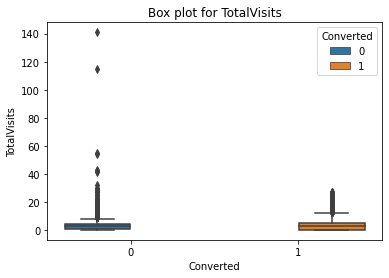

In [ ]:
f = sns.boxplot(x = 'Converted', y = train_df.columns[3], data = train_df, hue = 'Converted').set_title('Box plot for {}'.format(train_df.columns[3]))

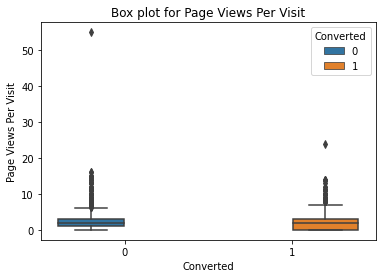

In [ ]:
f = sns.boxplot(x = 'Converted', y = train_df.columns[5], data = train_df, hue = 'Converted').set_title('Box plot for {}'.format(train_df.columns[5]))

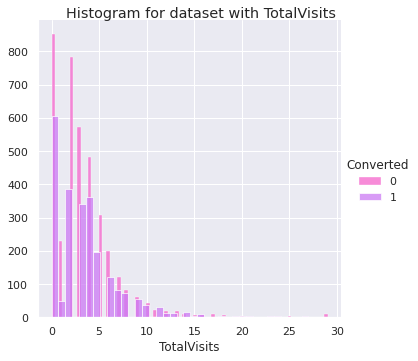

In [ ]:
f = sns.FacetGrid(train_df, hue = 'Converted', height=5).map(sns.histplot, train_df.columns[3])
f.add_legend()
f.fig.suptitle('Histogram for dataset with {}'.format(train_df.columns[3]), y=1)
plt.show()

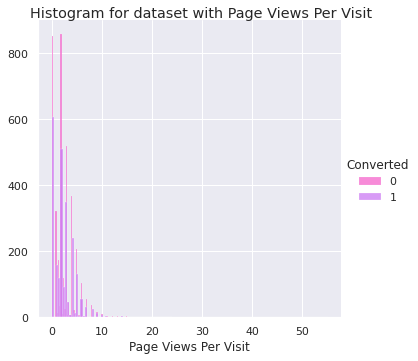

In [ ]:
f = sns.FacetGrid(train_df, hue = 'Converted', height=5).map(sns.histplot, train_df.columns[5])
f.add_legend()
f.fig.suptitle('Histogram for dataset with {}'.format(train_df.columns[5]), y=1)
plt.show()

Observations from above 4 plots:

1. For Total Visits, non converted have higher values than converted in general.
2. Since box plot treats values outside whiskers as outliers, but in our case we can't consider all these values as outliers as the number of visits depend on user behaviour and uncertainity as well. Some users may get converted even if they visit only once, our data reflects that the more the user visits the lesser chances are that it will convert.
3. From histplot for Total Visits, we can say that apart from points having higher values for not converted, the PDF for 2 classes almost overlap and this feature doesn't have much separation capability.
4. When we talk in terms of Page Views Per Visit, we can say that this is almost perfect overlap for both the classes and this feature doesn't have much separation capability, still let us consider the feature for now and see how it works for us.
5. Coming to imputing, we'll impute via mean value for a class. Mean imputation has a major disadvantage that it reduces variance in our data & variance is the source of actual information that we have. But still for this 1st cut solution we'll go ahead and follow mean imputation technique for this.
6. To check for high range outlier points, we'll look into percentile values and then will decide if we need to cap our range after a certain value.


In [ ]:
train_df[train_df['Converted'] == 0][train_df.columns[3]].describe()

count    3838.000000
mean        3.365555
std         4.662554
min         0.000000
25%         1.000000
50%         3.000000
75%         4.000000
max       141.000000
Name: TotalVisits, dtype: float64

In [ ]:
train_df[train_df['Converted'] == 1][train_df.columns[3]].describe()

count    2363.000000
mean        3.613204
std         3.788015
min         0.000000
25%         0.000000
50%         3.000000
75%         5.000000
max        27.000000
Name: TotalVisits, dtype: float64

After looking at these numbers it makes more sense to impute from using the IQR value for these..... As we see even though class 0 has max value of 141, it's mean value is less than class 1. So, let us consider the **IQR to impute the missing columns** for each class....

In [ ]:
train_df[train_df['Converted'] == 0][train_df.columns[5]].describe()

count    3838.000000
mean        2.387246
std         2.247919
min         0.000000
25%         1.000000
50%         2.000000
75%         3.000000
max        55.000000
Name: Page Views Per Visit, dtype: float64

In [ ]:
train_df[train_df['Converted'] == 1][train_df.columns[5]].describe()

count    2363.000000
mean        2.340106
std         2.118364
min         0.000000
25%         0.000000
50%         2.000000
75%         3.000000
max        24.000000
Name: Page Views Per Visit, dtype: float64

For this column as well, imputation will be based on IQR....

In [ ]:
train_df.loc[train_df[train_df.columns[3]].isnull(), train_df.columns[3]] = iqr(train_df[~train_df[train_df.columns[3]].isnull()][train_df.columns[3]])
test_df.loc[test_df[test_df.columns[3]].isnull(), test_df.columns[3]] = iqr(train_df[~train_df[train_df.columns[3]].isnull()][train_df.columns[3]])
cv_df.loc[cv_df[cv_df.columns[3]].isnull(), cv_df.columns[3]] = iqr(train_df[~train_df[train_df.columns[3]].isnull()][train_df.columns[3]])

train_df.loc[train_df[train_df.columns[5]].isnull(), train_df.columns[5]] = iqr(train_df[~train_df[train_df.columns[5]].isnull()][train_df.columns[5]])
test_df.loc[test_df[test_df.columns[5]].isnull(), test_df.columns[5]] = iqr(train_df[~train_df[train_df.columns[5]].isnull()][train_df.columns[5]])
cv_df.loc[cv_df[cv_df.columns[5]].isnull(), cv_df.columns[5]] = iqr(train_df[~train_df[train_df.columns[5]].isnull()][train_df.columns[5]])

In [ ]:
print(train_df[train_df[train_df.columns[3]].isnull()].shape, test_df[test_df[test_df.columns[3]].isnull()].shape, cv_df[cv_df[cv_df.columns[3]].isnull()].shape)

(0, 23) (0, 23) (0, 23)


In [ ]:
print(train_df[train_df[train_df.columns[5]].isnull()].shape, test_df[test_df[test_df.columns[5]].isnull()].shape, cv_df[cv_df[cv_df.columns[5]].isnull()].shape)

(0, 23) (0, 23) (0, 23)


In [ ]:
#Let us again check for columns with null values....
train_df.isnull().mean()

Lead Origin                                      0.000000
Lead Source                                      0.000000
Do Not Email                                     0.000000
TotalVisits                                      0.000000
Total Time Spent on Website                      0.000000
Page Views Per Visit                             0.000000
Last Activity                                    0.010027
Country                                          0.260544
Specialization                                   0.154067
How did you hear about X Education               0.239535
What is your current occupation                  0.288716
What matters most to you in choosing a course    0.290944
Tags                                             0.358109
Lead Quality                                     0.515677
Lead Profile                                     0.290944
City                                             0.151997
Asymmetrique Activity Index                      0.453446
Asymmetrique P

Last Activity is one column with null values, we also have Last Notable Activity, let us check how these columns are related and can be simply remove one if they have high relation..... 

In [ ]:
print('{} have {} missing rows.'.format('Last Activity', train_df[train_df['Last Activity'].isnull()].shape[0]))

Last Activity have 63 missing rows.


In [ ]:
train_df[['Last Activity', 'Last Notable Activity']].head(10)

,Last Activity,Last Notable Activity
6071,Olark Chat Conversation,Modified
4843,SMS Sent,SMS Sent
1095,Unreachable,Modified
809,Email Opened,Modified
3226,Email Opened,Email Opened
9052,Converted to Lead,Modified
8609,Email Opened,Email Opened
4540,SMS Sent,SMS Sent
279,Email Link Clicked,Email Link Clicked
1457,Email Opened,Modified


Let us see how these values maps to each other...

In [ ]:
for val in train_df['Last Notable Activity'].unique():
  print('{} : {}'.format(val, train_df[train_df['Last Notable Activity'] == val]['Last Activity'].unique()))

Modified : ['Olark Chat Conversation' 'Unreachable' 'Email Opened'
 'Converted to Lead' 'Page Visited on Website' 'SMS Sent' 'Email Bounced'
 'Form Submitted on Website' 'Email Link Clicked'
 'Had a Phone Conversation' nan 'Approached upfront' 'Unsubscribed'
 'View in browser link Clicked' 'Visited Booth in Tradeshow']
SMS Sent : ['SMS Sent']
Email Opened : ['Email Opened']
Email Link Clicked : ['Email Link Clicked']
Unreachable : ['Unreachable']
Page Visited on Website : ['Page Visited on Website']
Olark Chat Conversation : ['Olark Chat Conversation']
Had a Phone Conversation : ['Had a Phone Conversation']
Email Bounced : ['Email Bounced']
Unsubscribed : ['Unsubscribed']
Approached upfront : ['Approached upfront']
Form Submitted on Website : ['Form Submitted on Website']
Email Marked Spam : ['Email Marked Spam']
Email Received : ['Email Received']
Resubscribed to emails : ['Resubscribed to emails']


So, Modified is one field that is related to all the levels in Last Activity and even the null values in Last Activity are mapped to Modified in Last Notable Activity....

In [ ]:
print('% of fields with modified as a level for Last Notable Activity : {}'.format(round(train_df[train_df['Last Notable Activity'] == 'Modified'].shape[0] / train_df.shape[0] * 100), 2))

% of fields with modified as a level for Last Notable Activity : 36


In [ ]:
train_df[train_df['Last Activity'].isnull()]['Last Notable Activity'].unique()

array(['Modified'], dtype=object)

In [ ]:
train_df[train_df['Last Notable Activity'] == 'Modified']['Converted'].value_counts()

0    1760
1     525
Name: Converted, dtype: int64

In [ ]:
train_df[train_df['Last Notable Activity'] == 'Modified']['Last Activity'].value_counts()

Olark Chat Conversation         527
Email Opened                    406
SMS Sent                        390
Converted to Lead               289
Page Visited on Website         210
Email Bounced                   198
Form Submitted on Website        77
Email Link Clicked               56
Unreachable                      41
Unsubscribed                     11
Had a Phone Conversation         10
Approached upfront                3
View in browser link Clicked      3
Visited Booth in Tradeshow        1
Name: Last Activity, dtype: int64

In [ ]:
train_df.head()

,Lead Origin,Lead Source,Do Not Email,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Country,Specialization,How did you hear about X Education,What is your current occupation,What matters most to you in choosing a course,Tags,Lead Quality,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,A free copy of Mastering The Interview,Last Notable Activity,Converted
6071,API,Google,No,3.0,697,1.5,Olark Chat Conversation,India,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,Modified,0
4843,Lead Add Form,Reference,No,0.0,0,0.0,SMS Sent,NaN,Select,Select,Unemployed,Better Career Prospects,Will revert after reading the email,High in Relevance,Select,Select,NaN,NaN,NaN,NaN,No,SMS Sent,1
1095,Landing Page Submission,Google,No,2.0,539,2.0,Unreachable,India,International Business,Other,Unemployed,Better Career Prospects,switched off,Not Sure,Select,Mumbai,02.Medium,01.High,13.0,18.0,No,Modified,0
809,Lead Add Form,Reference,No,0.0,0,0.0,Email Opened,NaN,Hospitality Management,Select,Working Professional,Better Career Prospects,Interested in other courses,Low in Relevance,Other Leads,Other Cities,02.Medium,02.Medium,14.0,13.0,No,Modified,0
3226,Landing Page Submission,Google,No,2.0,183,2.0,Email Opened,India,"Banking, Investment And Insurance",Advertisements,Unemployed,Better Career Prospects,Ringing,Might be,Select,Other Cities,NaN,NaN,NaN,NaN,No,Email Opened,0


In [ ]:
train_df[train_df['Last Activity'].isnull()].head(50)

,Lead Origin,Lead Source,Do Not Email,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Country,Specialization,How did you hear about X Education,What is your current occupation,What matters most to you in choosing a course,Tags,Lead Quality,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,A free copy of Mastering The Interview,Last Notable Activity,Converted
5840,Lead Add Form,Reference,No,4.0,506,2.0,NaN,NaN,Select,Select,Unemployed,Better Career Prospects,NaN,NaN,Select,Select,NaN,NaN,NaN,NaN,No,Modified,1
6383,Lead Add Form,Reference,No,4.0,1660,2.0,NaN,NaN,Select,Select,Working Professional,Better Career Prospects,Closed by Horizzon,Might be,Select,Select,NaN,NaN,NaN,NaN,No,Modified,1
4900,Lead Add Form,Reference,No,4.0,1672,2.0,NaN,NaN,Select,Select,Unemployed,Better Career Prospects,Closed by Horizzon,High in Relevance,Select,Select,NaN,NaN,NaN,NaN,No,Modified,1
3064,Lead Add Form,Reference,No,4.0,278,2.0,NaN,NaN,Human Resource Management,Select,Working Professional,Flexibility & Convenience,Interested in other courses,Low in Relevance,Potential Lead,Thane & Outskirts,02.Medium,01.High,13.0,19.0,No,Modified,0
5942,Lead Add Form,Welingak Website,No,4.0,1024,2.0,NaN,NaN,Select,Select,Unemployed,Better Career Prospects,Closed by Horizzon,NaN,Select,Select,NaN,NaN,NaN,NaN,No,Modified,1
470,Lead Add Form,Reference,No,4.0,205,2.0,NaN,NaN,Finance Management,Select,Working Professional,Better Career Prospects,Closed by Horizzon,High in Relevance,Lateral Student,Select,02.Medium,01.High,14.0,18.0,No,Modified,1
6544,Lead Add Form,Reference,No,4.0,1558,2.0,NaN,NaN,Finance Management,Select,Unemployed,Better Career Prospects,Closed by Horizzon,High in Relevance,Potential Lead,Other Cities,NaN,NaN,NaN,NaN,No,Modified,1
5921,Lead Add Form,Reference,No,4.0,1385,2.0,NaN,NaN,Marketing Management,Select,Working Professional,Better Career Prospects,Closed by Horizzon,Low in Relevance,Student of SomeSchool,Other Cities,NaN,NaN,NaN,NaN,No,Modified,1
1137,Lead Import,Facebook,No,4.0,300,2.0,NaN,NaN,Select,Select,Unemployed,Better Career Prospects,Ringing,NaN,Select,Other Cities,02.Medium,02.Medium,13.0,13.0,No,Modified,0
8434,Lead Add Form,Reference,No,4.0,1458,2.0,NaN,NaN,Select,Select,Unemployed,Better Career Prospects,Closed by Horizzon,High in Relevance,Select,Select,02.Medium,01.High,14.0,17.0,No,Modified,1


After looking into above data, we can see some common attributes for few of the columns, let us just try to see what does the modal value comes out with these combinations....

In [ ]:
train_df[(train_df['Lead Origin'] == 'Lead Add Form') & (train_df['Do Not Email'] == 'No')
         & (train_df['TotalVisits'] == 4) & (train_df['Page Views Per Visit'] == 2)]['Last Activity'].value_counts()

Had a Phone Conversation    3
Email Bounced               3
Unreachable                 2
Name: Last Activity, dtype: int64

So for above rule based combination we have most of the null values, since SMS Sent is the 3rd highest occuring value across the data and is present in this combination as well, so **imputing all the missing value of this column with SMS Sent**....

In [ ]:
train_df.loc[train_df['Last Activity'].isnull(), 'Last Activity'] = 'SMS Sent'
test_df.loc[test_df['Last Activity'].isnull(), 'Last Activity'] = 'SMS Sent'
cv_df.loc[cv_df['Last Activity'].isnull(), 'Last Activity'] = 'SMS Sent'

In [ ]:
print(train_df[train_df['Last Activity'].isnull()].shape, test_df[test_df['Last Activity'].isnull()].shape, cv_df[cv_df['Last Activity'].isnull()].shape)

(0, 23) (0, 23) (0, 23)


In [ ]:
#Let us again check for columns with null values....
train_df.isnull().mean()

Lead Origin                                      0.000000
Lead Source                                      0.000000
Do Not Email                                     0.000000
TotalVisits                                      0.000000
Total Time Spent on Website                      0.000000
Page Views Per Visit                             0.000000
Last Activity                                    0.000000
Country                                          0.260544
Specialization                                   0.154067
How did you hear about X Education               0.239535
What is your current occupation                  0.288716
What matters most to you in choosing a course    0.290944
Tags                                             0.358109
Lead Quality                                     0.515677
Lead Profile                                     0.290944
City                                             0.151997
Asymmetrique Activity Index                      0.453446
Asymmetrique P

<h4> country & city </h4>

Country has almost 27% missing values, which is too much and the most logical way of imputing it is by telling that value is unknown.
This is not the stage where we are selecting final columns, feature selection process may vary, we may include or exculde the feature
for now let us just see what levels we have to verify if unknown is already present in data or not....

Let us start by looking into city details, this can be used to fill countries field if it has relevant information...

In [ ]:
train_df['City'].unique()

array([nan, 'Select', 'Mumbai', 'Other Cities', 'Thane & Outskirts',
       'Other Cities of Maharashtra', 'Other Metro Cities',
       'Tier II Cities'], dtype=object)

No... This is just noise, it only contains details about Mumbai, rejecting(dropping) this column....

In [ ]:
train_df = train_df.drop('City', axis = 1)
test_df = test_df.drop('City', axis = 1)
cv_df = cv_df.drop('City', axis = 1)

In [ ]:
train_df['Country'].unique()

array(['India', nan, 'United Arab Emirates', 'Saudi Arabia', 'Hong Kong',
       'United States', 'Singapore', 'Australia', 'Liberia', 'Bahrain',
       'Kuwait', 'Qatar', 'unknown', 'Germany', 'France',
       'United Kingdom', 'Nigeria', 'Canada', 'South Africa',
       'Philippines', 'Sweden', 'Italy', 'Ghana', 'China', 'Indonesia',
       'Netherlands', 'Tanzania', 'Vietnam', 'Malaysia', 'Bangladesh',
       'Sri Lanka', 'Asia/Pacific Region', 'Oman', 'Belgium',
       'Switzerland', 'Uganda'], dtype=object)

We can see that data already have unknown as one of the field, so we cannot impute another field with same definition to our data.....
Let us try to understand the frequency of data points using bar plot...

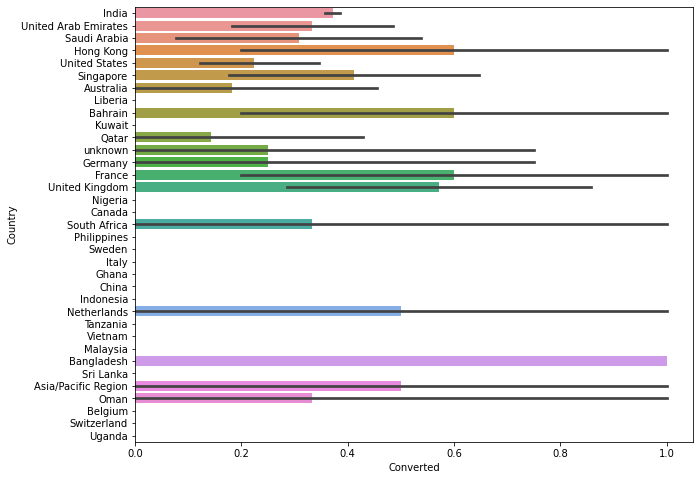

In [ ]:
plt.figure(figsize = (10, 8))
sns.barplot(x = 'Converted', y = 'Country', data = train_df)

Following observations we can see from above:
1. Countries with all lead equal to zero are the ones with no bar.
2. Countries with all the values as lead are the ones with bar without a line.
3. Other are the countries with mixed values.

Let us see what are the labels for the missing fields....

In [ ]:
train_df[train_df['Country'].isnull()]['Converted'].value_counts(normalize = True)

0    0.565669
1    0.434331
Name: Converted, dtype: float64

Now let us just check the distribution for Country == Unknown

In [ ]:
train_df[train_df['Country'] == 'unknown']['Converted'].value_counts(normalize = True)

0    0.75
1    0.25
Name: Converted, dtype: float64

Not making sense to simply impute these based on some other fields, we can definitely use some clustering mechanism to see where the data points are falling and accordingly decide on these fields, but this data have lot of missing values and lot of columns have high percentage missing fields, so it make sense to simply drop such columns. **Dropping Country column**

In [ ]:
train_df = train_df.drop('Country', axis = 1)
test_df = test_df.drop('Country', axis = 1)
cv_df = cv_df.drop('Country', axis = 1)

In [ ]:
train_df.isnull().mean()

Lead Origin                                      0.000000
Lead Source                                      0.000000
Do Not Email                                     0.000000
TotalVisits                                      0.000000
Total Time Spent on Website                      0.000000
Page Views Per Visit                             0.000000
Last Activity                                    0.000000
Specialization                                   0.154067
How did you hear about X Education               0.239535
What is your current occupation                  0.288716
What matters most to you in choosing a course    0.290944
Tags                                             0.358109
Lead Quality                                     0.515677
Lead Profile                                     0.290944
Asymmetrique Activity Index                      0.453446
Asymmetrique Profile Index                       0.453446
Asymmetrique Activity Score                      0.453446
Asymmetrique P

In [ ]:
train_df['How did you hear about X Education'].unique()

array([nan, 'Select', 'Other', 'Advertisements', 'Multiple Sources',
       'Online Search', 'Student of SomeSchool', 'Word Of Mouth',
       'Social Media', 'Email', 'SMS'], dtype=object)

In [ ]:
train_df[['Lead Origin', 'Lead Source', 'How did you hear about X Education']][train_df['How did you hear about X Education'].isnull()]['Lead Origin'].unique()

array(['API', 'Landing Page Submission', 'Lead Import'], dtype=object)

In [ ]:
train_df[['Lead Origin', 'Lead Source', 'How did you hear about X Education']][train_df['How did you hear about X Education'].isnull()]

,Lead Origin,Lead Source,How did you hear about X Education
6071,API,Google,NaN
9052,API,Organic Search,NaN
279,API,Referral Sites,NaN
2477,API,Olark Chat,NaN
4685,API,Google,NaN
...,...,...,...
8386,API,Olark Chat,NaN
4639,Landing Page Submission,Direct Traffic,NaN
9038,Landing Page Submission,Direct Traffic,NaN
2120,API,Olark Chat,NaN


In [ ]:
train_df[(train_df['Lead Origin'] == 'API') & (train_df['Lead Source'] == 'Google')]['How did you hear about X Education'].unique()

array([nan, 'Select', 'Student of SomeSchool', 'Online Search',
       'Social Media', 'Word Of Mouth', 'Other', 'Multiple Sources'],
      dtype=object)

**Tried establishing a connection from lead origin and lead source to this missing column field, but unable to find a pattern that can help us with imputation, hence dropping the column.**

In [ ]:
train_df = train_df.drop('How did you hear about X Education', axis = 1)
test_df = test_df.drop('How did you hear about X Education', axis = 1)
cv_df = cv_df.drop('How did you hear about X Education', axis = 1)

Let us look at Specialization, What is your current occupation, What matters most to you in choosing this course

In [ ]:
train_df['Specialization'].unique()

array([nan, 'Select', 'International Business', 'Hospitality Management',
       'Banking, Investment And Insurance', 'Supply Chain Management',
       'Human Resource Management', 'IT Projects Management',
       'Business Administration', 'Finance Management',
       'Marketing Management', 'Operations Management',
       'Travel and Tourism', 'E-COMMERCE', 'Healthcare Management',
       'Media and Advertising', 'Retail Management', 'E-Business',
       'Rural and Agribusiness', 'Services Excellence'], dtype=object)

In [ ]:
train_df['What is your current occupation'].unique()

array([nan, 'Unemployed', 'Working Professional', 'Student', 'Other',
       'Businessman', 'Housewife'], dtype=object)

In [ ]:
train_df['What matters most to you in choosing a course'].unique()

array([nan, 'Better Career Prospects', 'Flexibility & Convenience',
       'Other'], dtype=object)

what matters most to you in choosing a course does not have many leaves. Also, it has 28 % missing values... So dropping this column...

In [ ]:
train_df = train_df.drop('What matters most to you in choosing a course', axis = 1)
test_df = test_df.drop('What matters most to you in choosing a course', axis = 1)
cv_df = cv_df.drop('What matters most to you in choosing a course', axis = 1)

**what is your current occupation, can have a level like unknown, which can indicate that we were unable to record this information, so, imputing the missing values with unknown field....**

In [ ]:
train_df.loc[train_df['What is your current occupation'].isnull(), 'What is your current occupation'] = 'unk'
test_df.loc[test_df['What is your current occupation'].isnull(), 'What is your current occupation'] = 'unk'
cv_df.loc[cv_df['What is your current occupation'].isnull(), 'What is your current occupation'] = 'unk'

**Even for specialization performing the same method of imputation....**

In [ ]:
train_df.loc[train_df['Specialization'].isnull(), 'Specialization'] = 'unk'
test_df.loc[test_df['Specialization'].isnull(), 'Specialization'] = 'unk'
cv_df.loc[cv_df['Specialization'].isnull(), 'Specialization'] = 'unk'

In [ ]:
train_df.isnull().mean()

Lead Origin                               0.000000
Lead Source                               0.000000
Do Not Email                              0.000000
TotalVisits                               0.000000
Total Time Spent on Website               0.000000
Page Views Per Visit                      0.000000
Last Activity                             0.000000
Specialization                            0.000000
What is your current occupation           0.000000
Tags                                      0.358109
Lead Quality                              0.515677
Lead Profile                              0.290944
Asymmetrique Activity Index               0.453446
Asymmetrique Profile Index                0.453446
Asymmetrique Activity Score               0.453446
Asymmetrique Profile Score                0.453446
A free copy of Mastering The Interview    0.000000
Last Notable Activity                     0.000000
Converted                                 0.000000
dtype: float64

Now we are left out with columns with high % of missing values, we are not going to spend much time on these are if they are not making much sense, we'll directly drop them.... The more external imputation we do on independent variables, more probability of adding noise to them and eventually this will impact model's performance....

In [ ]:
#checking for tgs, Lead Quality & Lead Profile....
train_df[['Tags', 'Lead Quality', 'Lead Profile']]

,Tags,Lead Quality,Lead Profile
6071,NaN,NaN,NaN
4843,Will revert after reading the email,High in Relevance,Select
1095,switched off,Not Sure,Select
809,Interested in other courses,Low in Relevance,Other Leads
3226,Ringing,Might be,Select
...,...,...,...
3052,NaN,NaN,Select
8051,NaN,NaN,Select
2384,Will revert after reading the email,High in Relevance,Potential Lead
457,Ringing,Not Sure,Select


In [ ]:
train_df['Tags'].unique()

array([nan, 'Will revert after reading the email', 'switched off',
       'Interested in other courses', 'Ringing', 'opp hangup',
       'Already a student', 'Interested in Next batch',
       'Closed by Horizzon', 'Diploma holder (Not Eligible)',
       'Graduation in progress', 'Interested  in full time MBA',
       'invalid number', 'Lost to EINS', 'in touch with EINS',
       'wrong number given', 'Not doing further education', 'Busy',
       'Lateral student', 'number not provided',
       'Shall take in the next coming month',
       'Want to take admission but has financial problems',
       'Lost to Others', 'In confusion whether part time or DLP',
       'Recognition issue (DEC approval)', 'Still Thinking',
       'University not recognized'], dtype=object)

In [ ]:
for val in train_df['Tags'].unique():
  print('{} : {}'.format(val, train_df[train_df['Tags'] == val]['Lead Quality'].unique()))

nan : []
Will revert after reading the email : ['High in Relevance' 'Might be' 'Low in Relevance' 'Not Sure' nan 'Worst']
switched off : ['Not Sure' 'Might be' nan 'Worst']
Interested in other courses : ['Low in Relevance' nan 'Not Sure' 'Worst' 'Might be' 'High in Relevance']
Ringing : ['Might be' nan 'Not Sure' 'High in Relevance' 'Worst' 'Low in Relevance']
opp hangup : ['Not Sure' nan 'Worst']
Already a student : ['Worst' nan 'Might be' 'Not Sure' 'High in Relevance' 'Low in Relevance']
Interested in Next batch : ['Might be' 'Low in Relevance' 'High in Relevance']
Closed by Horizzon : ['High in Relevance' 'Low in Relevance' nan 'Might be' 'Not Sure' 'Worst']
Diploma holder (Not Eligible) : ['Not Sure' 'Worst' nan 'High in Relevance' 'Might be' 'Low in Relevance']
Graduation in progress : ['Worst' nan 'Low in Relevance' 'Might be' 'Not Sure' 'High in Relevance']
Interested  in full time MBA : ['Not Sure' 'Worst' nan 'Might be' 'Low in Relevance']
invalid number : ['Worst' nan 'Might

In [ ]:
for val in train_df['Tags'].unique():
  print('{} : {}'.format(val, train_df[train_df['Tags'] == val]['Lead Profile'].unique()))

nan : []
Will revert after reading the email : ['Select' 'Potential Lead' 'Other Leads' 'Dual Specialization Student'
 'Lateral Student' 'Student of SomeSchool']
switched off : ['Select' 'Other Leads' 'Potential Lead']
Interested in other courses : ['Other Leads' 'Select' nan 'Potential Lead']
Ringing : ['Select' 'Potential Lead' 'Other Leads']
opp hangup : ['Potential Lead' 'Select' 'Other Leads']
Already a student : ['Potential Lead' 'Student of SomeSchool' 'Select' 'Lateral Student'
 'Other Leads']
Interested in Next batch : ['Select' 'Potential Lead']
Closed by Horizzon : ['Potential Lead' 'Select' 'Other Leads' 'Lateral Student'
 'Student of SomeSchool']
Diploma holder (Not Eligible) : ['Select' 'Potential Lead' 'Other Leads']
Graduation in progress : ['Other Leads' 'Select' 'Potential Lead']
Interested  in full time MBA : ['Select' 'Other Leads' 'Potential Lead' 'Student of SomeSchool']
invalid number : ['Select' 'Other Leads' 'Potential Lead' 'Student of SomeSchool']
Lost to EIN

**Looking at these values it doesn't seem that we can identify ways of imputation, plus the % of missing values is on higher side, hence dropping all these columns from the dataset....**

In [ ]:
train_df = train_df.drop(['Tags', 'Lead Profile', 'Lead Quality'], axis = 1)
test_df = test_df.drop(['Tags', 'Lead Profile', 'Lead Quality'], axis = 1)
cv_df = cv_df.drop(['Tags', 'Lead Profile', 'Lead Quality'], axis = 1)

In [ ]:
train_df.isnull().mean()

Lead Origin                               0.000000
Lead Source                               0.000000
Do Not Email                              0.000000
TotalVisits                               0.000000
Total Time Spent on Website               0.000000
Page Views Per Visit                      0.000000
Last Activity                             0.000000
Specialization                            0.000000
What is your current occupation           0.000000
Asymmetrique Activity Index               0.453446
Asymmetrique Profile Index                0.453446
Asymmetrique Activity Score               0.453446
Asymmetrique Profile Score                0.453446
A free copy of Mastering The Interview    0.000000
Last Notable Activity                     0.000000
Converted                                 0.000000
dtype: float64

**Finally we have Index and Score given to users based on activity and profile, but this information is already on 46% missing values, no point in thinking much about these and can be directly dropped from the data.....**

In [ ]:
train_df = train_df.drop(['Asymmetrique Activity Index', 'Asymmetrique Profile Index', 'Asymmetrique Activity Score', 'Asymmetrique Profile Score'], axis = 1)
test_df = test_df.drop(['Asymmetrique Activity Index', 'Asymmetrique Profile Index', 'Asymmetrique Activity Score', 'Asymmetrique Profile Score'], axis = 1)
cv_df = cv_df.drop(['Asymmetrique Activity Index', 'Asymmetrique Profile Index', 'Asymmetrique Activity Score', 'Asymmetrique Profile Score'], axis = 1)

In [ ]:
print(train_df.shape, test_df.shape, cv_df.shape)

(6283, 12) (1848, 12) (1109, 12)


Finally we are done with missing values, lot of assumptions were taken into consideration and based on basic undertanding of data fields from data schema decisions were taken. 

There are lot of ways in which we can handle missing values, here since the amount of missing fields were high we were unable to impute them and since this is the first cut solution, gone with what looked to be the best way of imputing the fields that were imputed.

A detail analysis can help us better, also, domained inputs can help us better at times when we handle missing values. When taking domain inputs we need to be very careful as this can at times add bias to our data as well..... Imputation exercise should be done very carefully, as it may add bias and eventually reduce variance of the data....

In [ ]:
print('After dealing with missing valued columns, we are left with following columns: {}'.format(list(train_df.columns)))

After dealing with missing valued columns, we are left with following columns: ['Lead Origin', 'Lead Source', 'Do Not Email', 'TotalVisits', 'Total Time Spent on Website', 'Page Views Per Visit', 'Last Activity', 'Specialization', 'What is your current occupation', 'A free copy of Mastering The Interview', 'Last Notable Activity', 'Converted']


In [ ]:
train_df.head()

,Lead Origin,Lead Source,Do Not Email,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Specialization,What is your current occupation,A free copy of Mastering The Interview,Last Notable Activity,Converted
6071,API,Google,No,3.0,697,1.5,Olark Chat Conversation,unk,unk,No,Modified,0
4843,Lead Add Form,Reference,No,0.0,0,0.0,SMS Sent,Select,Unemployed,No,SMS Sent,1
1095,Landing Page Submission,Google,No,2.0,539,2.0,Unreachable,International Business,Unemployed,No,Modified,0
809,Lead Add Form,Reference,No,0.0,0,0.0,Email Opened,Hospitality Management,Working Professional,No,Modified,0
3226,Landing Page Submission,Google,No,2.0,183,2.0,Email Opened,"Banking, Investment And Insurance",Unemployed,No,Email Opened,0


Data Detail:
1. Target Variable: Binary(Binary Classification problem)
2. Continous variables: 3
3. Categorical Variables: 8

Let us see if we can understand these columns more before coming to the modeling part.

In [ ]:
#Let us check the correlation between continous variables...
train_df[['TotalVisits', 'Total Time Spent on Website', 'Page Views Per Visit']].corr()

,TotalVisits,Total Time Spent on Website,Page Views Per Visit
TotalVisits,1.000000,0.247135,0.581571
Total Time Spent on Website,0.247135,1.000000,0.295365
Page Views Per Visit,0.581571,0.295365,1.000000


This looks ok.... We can have all of these in our data....
One thing to note is that these numbers can't be trusted as at this point all these are on different scales..... 

Let us ask some Questions related to these variables and try to make conclusion...

1. What does the PDF looks like for these variables ?
2. Is the Distribution symmetrical or skewed, if skewed than what is the skewness?
3. Do we see this skewness because of the outlier points or is it because of the nature of the variable ?
4. If we have some outlier points, how should we treat them ?
5. For each class how does the separation capability looks like ?


<h4> 'TotalVisits', 'Total Time Spent on Website', 'Page Views Per Visit' </h4>

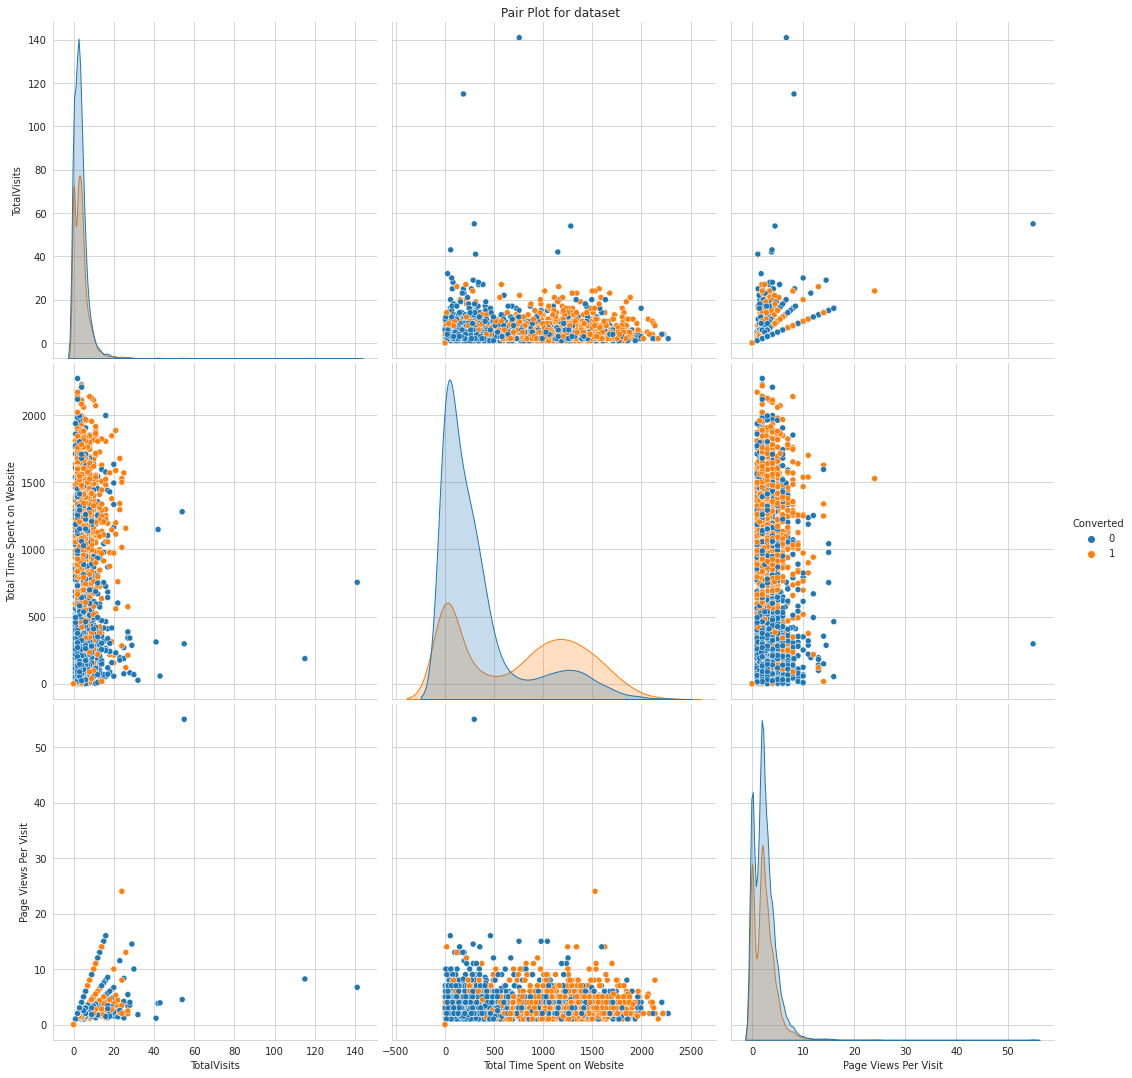

In [ ]:
#pair Plot
sns.set_style('whitegrid');
sns.pairplot(train_df, hue = 'Converted', vars = ['TotalVisits', 'Total Time Spent on Website', 'Page Views Per Visit'], height = 5).fig.suptitle('Pair Plot for dataset', y=1)
plt.show()

From above plot we can make following conclusions:
1. For all these 3 variables, PDF is non symmetric and is skewed to right(This was already seen in data.describe() when we saw that mean value > median).
2. We can't comment much on the outlier points from this, we need to dig deep into the variables individually to understand that.
3. We do see that these variables have some sense of separability for these classes and can be termed as important for our modeling purpose.
4. Like we saw with our correlational coefficients, some relation these variables we do see between Total Visits & Page Views Per Visit.

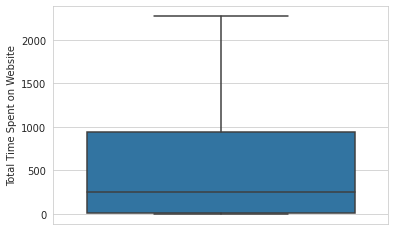

In [ ]:
sns.boxplot(y= 'Total Time Spent on Website', data = train_df)
plt.show()

This column seems to hold high relevance

In [ ]:
for percent in range(0,100,10):
  var = train_df['Total Time Spent on Website'].values
  var = np.sort(var, axis = None)
  print('{} percentile value is {}'.format(percent, var[int(len(var) * (float(percent) / 100))]))
print ('100 percentile value is {}'.format(var[-1]))

0 percentile value is 0
10 percentile value is 0
20 percentile value is 0
30 percentile value is 60
40 percentile value is 151
50 percentile value is 251
60 percentile value is 379
70 percentile value is 727
80 percentile value is 1102
90 percentile value is 1385
100 percentile value is 2272


This seems to have no outlier points, although even the 1st quartile is 0, but then in our data we would have users who have not visited the page and so we see these values, let us not try to cap this data....

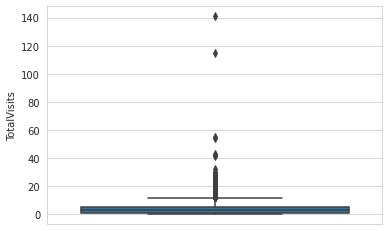

In [ ]:
sns.boxplot(y= 'TotalVisits', data = train_df)
plt.show()

Total number of visits seems to have lot of high points that could be termed as outliers, but we should not cap them as well, as user may visit again and again for number of reason, still let us look at percentile values....

In [ ]:
for percent in range(0,100,10):
  var = train_df['TotalVisits'].values
  var = np.sort(var, axis = None)
  print('{} percentile value is {}'.format(percent, var[int(len(var) * (float(percent) / 100))]))
print ('100 percentile value is {}'.format(var[-1]))

0 percentile value is 0.0
10 percentile value is 0.0
20 percentile value is 0.0
30 percentile value is 2.0
40 percentile value is 2.0
50 percentile value is 3.0
60 percentile value is 3.0
70 percentile value is 4.0
80 percentile value is 5.0
90 percentile value is 7.0
100 percentile value is 141.0


90th percentile value is 7 and 100th is 251, let us zoom further on this....

In [ ]:
for percent in range(90,100):
  var = train_df['TotalVisits'].values
  var = np.sort(var, axis = None)
  print("{} percentile value is {}".format(percent, var[int(len(var) * (float(percent)/100))]))
print ("100 percentile value is {}".format(var[-1]))

90 percentile value is 7.0
91 percentile value is 8.0
92 percentile value is 8.0
93 percentile value is 9.0
94 percentile value is 9.0
95 percentile value is 10.0
96 percentile value is 10.0
97 percentile value is 12.0
98 percentile value is 14.0
99 percentile value is 18.0
100 percentile value is 141.0


again 99th percentile is 17 and we see 251 as 100th percentile, let us zoom further on this...

In [ ]:
for percent in np.arange(0.0, 1.0, 0.1):
  var = train_df['TotalVisits'].values
  var = np.sort(var,axis = None)
  print("{} percentile value is {}".format(99 + percent, var[int(len(var) * (float(99 + percent) / 100))]))
print("100 percentile value is {}".format(var[-1]))

99.0 percentile value is 18.0
99.1 percentile value is 18.0
99.2 percentile value is 19.0
99.3 percentile value is 20.0
99.4 percentile value is 21.0
99.5 percentile value is 23.0
99.6 percentile value is 24.0
99.7 percentile value is 26.0
99.8 percentile value is 27.0
99.9 percentile value is 41.0
100 percentile value is 141.0


ok, we do have one point which is 251, this is definitely an outlier point that we need to treat, let us just cap it with the 99.9 percentile value....

In [ ]:
train_df['TotalVisits'] = np.where((train_df['TotalVisits'] > 29.0), 29.0, train_df['TotalVisits'])
#replicating the same for test and cv data as well
test_df['TotalVisits'] = np.where((test_df['TotalVisits'] > 29.0), 29.0, test_df['TotalVisits'])
cv_df['TotalVisits'] = np.where((cv_df['TotalVisits'] > 29.0), 29.0, cv_df['TotalVisits'])

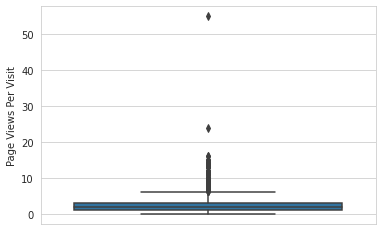

In [ ]:
#Let us do a similar kind of analysis for 'Page Views Per Visit'
sns.boxplot(y= 'Page Views Per Visit', data = train_df)
plt.show()

This looks like with lot of outlier, but let us dig into the percentile values to decide on final treatment

In [ ]:
for percent in range(0,100,10):
  var = train_df['Page Views Per Visit'].values
  var = np.sort(var, axis = None)
  print('{} percentile value is {}'.format(percent, var[int(len(var) * (float(percent) / 100))]))
print ('100 percentile value is {}'.format(var[-1]))

0 percentile value is 0.0
10 percentile value is 0.0
20 percentile value is 0.0
30 percentile value is 1.0
40 percentile value is 2.0
50 percentile value is 2.0
60 percentile value is 2.5
70 percentile value is 3.0
80 percentile value is 4.0
90 percentile value is 5.0
100 percentile value is 55.0


In [ ]:
for percent in range(90,100):
  var = train_df['Page Views Per Visit'].values
  var = np.sort(var, axis = None)
  print("{} percentile value is {}".format(percent, var[int(len(var) * (float(percent)/100))]))
print ("100 percentile value is {}".format(var[-1]))

90 percentile value is 5.0
91 percentile value is 5.0
92 percentile value is 5.0
93 percentile value is 5.0
94 percentile value is 6.0
95 percentile value is 6.0
96 percentile value is 6.0
97 percentile value is 7.0
98 percentile value is 8.0
99 percentile value is 9.0
100 percentile value is 55.0


In [ ]:
for percent in np.arange(0.0, 1.0, 0.1):
  var = train_df['Page Views Per Visit'].values
  var = np.sort(var,axis = None)
  print("{} percentile value is {}".format(99 + percent, var[int(len(var) * (float(99 + percent) / 100))]))
print("100 percentile value is {}".format(var[-1]))

99.0 percentile value is 9.0
99.1 percentile value is 9.0
99.2 percentile value is 10.0
99.3 percentile value is 10.0
99.4 percentile value is 10.0
99.5 percentile value is 11.0
99.6 percentile value is 11.5
99.7 percentile value is 13.0
99.8 percentile value is 14.0
99.9 percentile value is 15.0
100 percentile value is 55.0


page views per visit is highly skewed towards right, but still these numbers seems reasonable, the jump is not too high, hence not considering these points as outliers and keeping data as it is....

<h3> Categorical Data Analysis </h3>

In [ ]:
train_df.columns

Index(['Lead Origin', 'Lead Source', 'Do Not Email', 'TotalVisits',
       'Total Time Spent on Website', 'Page Views Per Visit', 'Last Activity',
       'Specialization', 'What is your current occupation',
       'A free copy of Mastering The Interview', 'Last Notable Activity',
       'Converted'],
      dtype='object')

In [ ]:
cat_df = train_df[list(train_df.columns[0 : 3]) + list(train_df.columns[6 : -1])]

Let us start by creating a relational plot to understand the degree of one to one mapping between these variables.....

In [ ]:
cat_df

,Lead Origin,Lead Source,Do Not Email,Last Activity,Specialization,What is your current occupation,A free copy of Mastering The Interview,Last Notable Activity
6071,API,Google,No,Olark Chat Conversation,unk,unk,No,Modified
4843,Lead Add Form,Reference,No,SMS Sent,Select,Unemployed,No,SMS Sent
1095,Landing Page Submission,Google,No,Unreachable,International Business,Unemployed,No,Modified
809,Lead Add Form,Reference,No,Email Opened,Hospitality Management,Working Professional,No,Modified
3226,Landing Page Submission,Google,No,Email Opened,"Banking, Investment And Insurance",Unemployed,No,Email Opened
...,...,...,...,...,...,...,...,...
3052,API,Olark Chat,No,Email Opened,Select,Unemployed,No,Email Opened
8051,API,Google,No,Email Link Clicked,Select,Unemployed,No,Email Link Clicked
2384,Lead Add Form,Reference,No,SMS Sent,Marketing Management,Unemployed,No,Modified
457,Landing Page Submission,Google,No,SMS Sent,Finance Management,Unemployed,No,Modified


In [ ]:
rel = {col : cat_df[cat_df.columns].pivot_table(index = col, aggfunc = lambda x : len(x.unique())).apply(np.max) for col in cat_df.columns}

In [ ]:
rel_df = pd.DataFrame(rel)
new_index = list(rel_df.columns)
rel_df = rel_df.reindex(new_index)
rel_df

,Lead Origin,Lead Source,Do Not Email,Last Activity,Specialization,What is your current occupation,A free copy of Mastering The Interview,Last Notable Activity
Lead Origin,NaN,2.0,5.0,5.0,5.0,5.0,5.0,5.0
Lead Source,12.0,NaN,16.0,14.0,11.0,15.0,18.0,14.0
Do Not Email,2.0,2.0,NaN,2.0,2.0,2.0,2.0,2.0
Last Activity,16.0,14.0,16.0,NaN,13.0,15.0,17.0,14.0
Specialization,20.0,20.0,20.0,20.0,NaN,20.0,20.0,20.0
What is your current occupation,7.0,7.0,7.0,7.0,6.0,NaN,7.0,7.0
A free copy of Mastering The Interview,2.0,2.0,2.0,2.0,2.0,2.0,NaN,2.0
Last Notable Activity,14.0,13.0,12.0,2.0,11.0,12.0,13.0,NaN


From above we were trying to understand the 1-1 relationship between these variables, from above figure it seems that none of these categorical features have a 1-1 map between them, we do ignore binary variables when we try to identify 1-1 map and so ignoring the ones in this case as well....

A very simple univariate analysis for all the categorical columns....

In [ ]:
def feature_analysis(feature):
  '''
  This function takes a feature and gives some descriptive analysis 
  for our categorical feature
  '''
  unique = train_df[feature].value_counts()
  print('Number of Unique values for feature {} is: {}'.format(feature, unique.shape[0]))
  print(unique.head(10))
  print('\nThere are {} different categories of {} in train data, and they are distibuted as follows'.format(unique.shape[0], feature))

  print('\n\nLet us check the distribution of these unique features....')
  s = sum(unique.values)
  h = unique.values/s
  plt.plot(h, label = 'Histrogram of {}'.format(feature))
  plt.xlabel('Index of {}'.format(feature))
  plt.ylabel('Number of Occurances')
  plt.legend()
  plt.grid()
  plt.show()

  print('\n\n')
  c = np.cumsum(h)
  plt.plot(c, label = 'Cumulative distribution of {}'.format(feature))
  plt.grid()
  plt.legend()
  plt.show()

**Calling the function for all the features**, questions that it'll answer:

1. Number of unqiue values
2. How they are distributed, based on frequency along with the CDF of the feature.

Number of Unique values for feature Lead Origin is: 5
Landing Page Submission    3343
API                        2436
Lead Add Form               468
Lead Import                  35
Quick Add Form                1
Name: Lead Origin, dtype: int64

There are 5 different categories of Lead Origin in train data, and they are distibuted as follows


Let us check the distribution of these unique features....


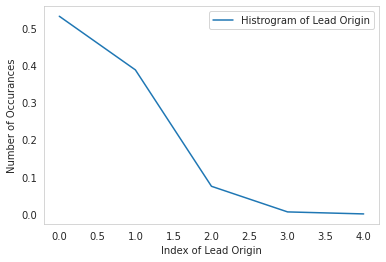

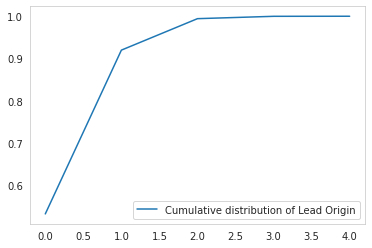

In [ ]:
feature_analysis(cat_df.columns[0])

Number of Unique values for feature Lead Source is: 19
Google              1962
Direct Traffic      1741
Olark Chat          1185
Organic Search       791
Reference            369
Welingak Website      94
Referral Sites        90
Facebook              35
bing                   3
Click2call             3
Name: Lead Source, dtype: int64

There are 19 different categories of Lead Source in train data, and they are distibuted as follows


Let us check the distribution of these unique features....


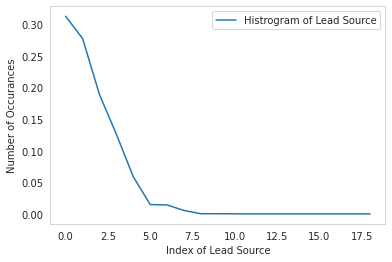

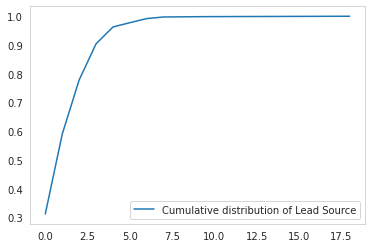

In [ ]:
feature_analysis(cat_df.columns[1])

Number of Unique values for feature Do Not Email is: 2
No     5759
Yes     524
Name: Do Not Email, dtype: int64

There are 2 different categories of Do Not Email in train data, and they are distibuted as follows


Let us check the distribution of these unique features....


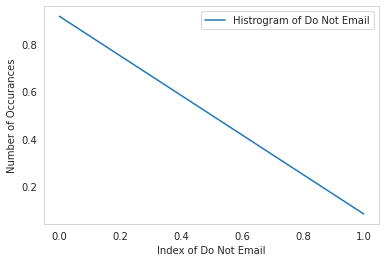

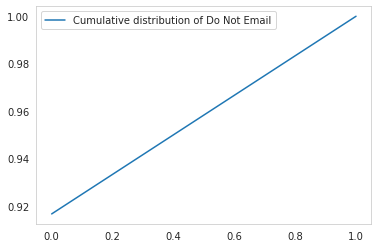

In [ ]:
feature_analysis(cat_df.columns[2])

Number of Unique values for feature Last Activity is: 17
Email Opened                 2339
SMS Sent                     1930
Olark Chat Conversation       655
Page Visited on Website       442
Converted to Lead             289
Email Bounced                 237
Email Link Clicked            175
Form Submitted on Website      78
Unreachable                    63
Unsubscribed                   43
Name: Last Activity, dtype: int64

There are 17 different categories of Last Activity in train data, and they are distibuted as follows


Let us check the distribution of these unique features....


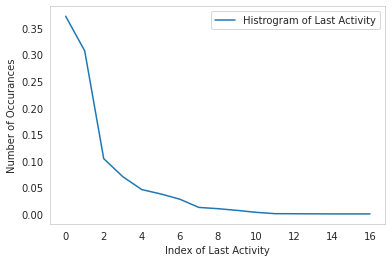

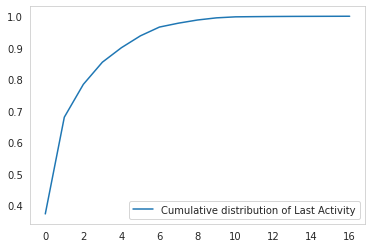

In [ ]:
feature_analysis(cat_df.columns[3])

Number of Unique values for feature Specialization is: 20
Select                               1316
unk                                   968
Finance Management                    635
Human Resource Management             579
Marketing Management                  571
Operations Management                 350
Business Administration               272
IT Projects Management                252
Banking, Investment And Insurance     246
Supply Chain Management               243
Name: Specialization, dtype: int64

There are 20 different categories of Specialization in train data, and they are distibuted as follows


Let us check the distribution of these unique features....


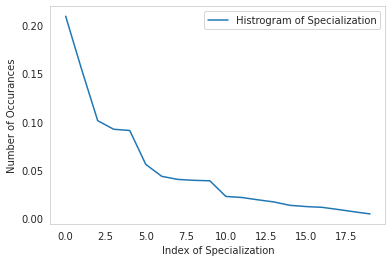

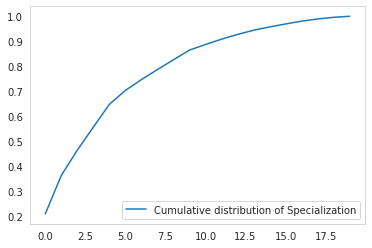

In [ ]:
feature_analysis(cat_df.columns[4])

Number of Unique values for feature What is your current occupation is: 7
Unemployed              3814
unk                     1814
Working Professional     496
Student                  140
Other                     11
Businessman                4
Housewife                  4
Name: What is your current occupation, dtype: int64

There are 7 different categories of What is your current occupation in train data, and they are distibuted as follows


Let us check the distribution of these unique features....


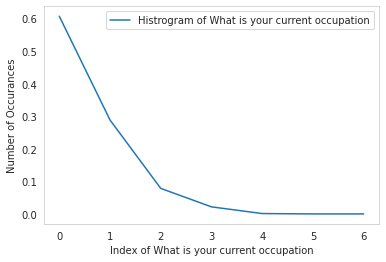

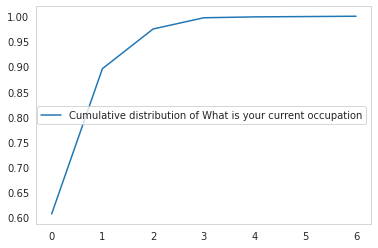

In [ ]:
feature_analysis(cat_df.columns[5])

Number of Unique values for feature A free copy of Mastering The Interview is: 2
No     4337
Yes    1946
Name: A free copy of Mastering The Interview, dtype: int64

There are 2 different categories of A free copy of Mastering The Interview in train data, and they are distibuted as follows


Let us check the distribution of these unique features....


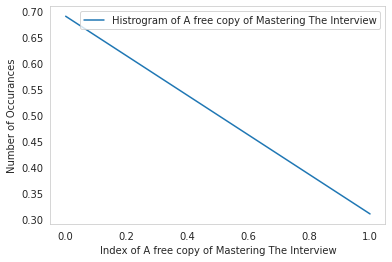

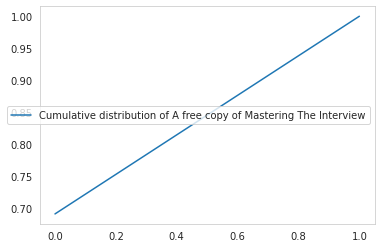

In [ ]:
feature_analysis(cat_df.columns[6])

Number of Unique values for feature Last Notable Activity is: 15
Modified                    2285
Email Opened                1933
SMS Sent                    1477
Page Visited on Website      232
Olark Chat Conversation      128
Email Link Clicked           119
Email Bounced                 39
Unsubscribed                  32
Unreachable                   22
Had a Phone Conversation      10
Name: Last Notable Activity, dtype: int64

There are 15 different categories of Last Notable Activity in train data, and they are distibuted as follows


Let us check the distribution of these unique features....


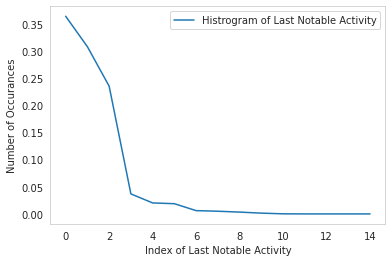

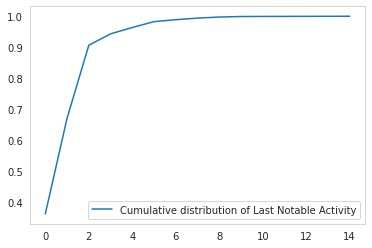

In [ ]:
feature_analysis(cat_df.columns[7])

These cells told us about the number of unique values for each category and also if we'll look at cdf, it'll the count of values along with the percentage.... 

**We are good with the EDA for now, let us go ahead and build a baseline model to have a base score.**

#Prediction using Random Model

Before we start let us build a random model and try to make predictions using the same. This random model can be thought of as our basline model for our analysis going forward..... In this we'll generate the class probabilities randomly.... At the end our probabilities should sum to 1.

In [ ]:
def plot_confusion_matrix(test_y, predict_y):
  '''
  This function takes predicted and actual labels and 
  plot confusion matrix, also plots recall matrix & 
  precision matrix for us.
  '''
  c_matrix = confusion_matrix(test_y, predict_y)

  recall_matrix =(((c_matrix.T) / (c_matrix.sum(axis=1))).T)
  precision_matrix =(c_matrix / c_matrix.sum(axis=0))

  labels = [0, 1]

  print("-"*20, "Confusion matrix", "-"*20)
  plt.figure(figsize=(10,5))
  sns.heatmap(c_matrix, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
  plt.xlabel('Predicted Class')
  plt.ylabel('Original Class')
  plt.show()

  print("-"*20, "Precision matrix ", "-"*20)
  plt.figure(figsize=(10,5))
  sns.heatmap(precision_matrix, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
  plt.xlabel('Predicted Class')
  plt.ylabel('Original Class')
  plt.show()

  print("-"*20, "Recall matrix", "-"*20)
  plt.figure(figsize=(10,5))
  sns.heatmap(recall_matrix, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
  plt.xlabel('Predicted Class')
  plt.ylabel('Original Class')
  plt.show()  

Log loss on Cross Validation Data using Random Model 0.8830826896227042
Log loss on Test Data using Random Model 0.9025137579008665
-------------------- Confusion matrix --------------------


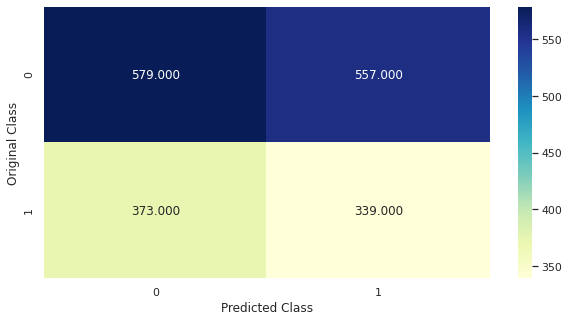

-------------------- Precision matrix  --------------------


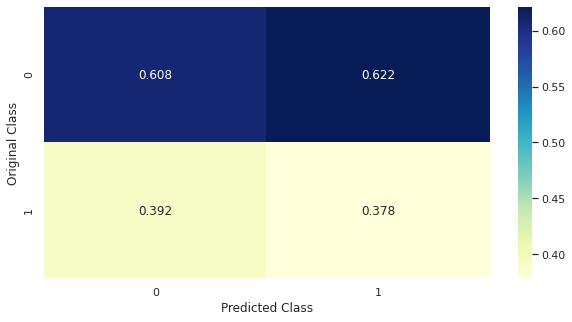

-------------------- Recall matrix --------------------


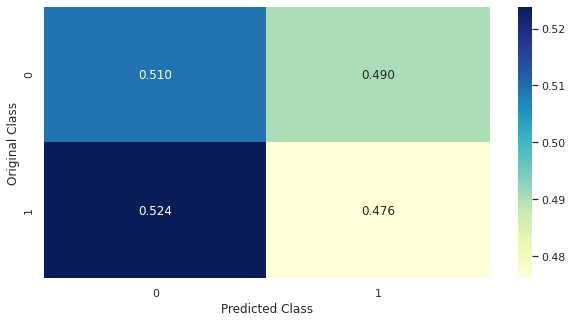

In [ ]:
# we need to generate 2 numbers and the sum of numbers should be 1
# one solution is to genarate 2 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
test_data_len = test_df.shape[0]
cv_data_len = cv_df.shape[0]

cv_predicted_y = np.zeros((cv_data_len,2))
for i in range(cv_data_len):
  rand_probs = np.random.rand(1,2)
  cv_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Cross Validation Data using Random Model",log_loss(y_cv,cv_predicted_y, eps=1e-15))


test_predicted_y = np.zeros((test_data_len, 2))
for i in range(test_data_len):
  rand_probs = np.random.rand(1, 2)
  test_predicted_y[i] = ((rand_probs / sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test , test_predicted_y, eps=1e-15))

predicted_y =np.argmax(test_predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

In [ ]:
test_predicted_y

array([[0.85953853, 0.14046147],
       [0.47124808, 0.52875192],
       [0.263989  , 0.736011  ],
       ...,
       [0.13018997, 0.86981003],
       [0.62120906, 0.37879094],
       [0.23877856, 0.76122144]])

Log Loss is a very good measure when we are trying to predict probab, as it penalizes heavily for small deviation, but log loss has the problem that what value should be say is good, so we have built a baseline model. If we get a log loss value of > than the one we get from simple random model, it will mean that our model is performing bad then a simple baseline model. We need to see how much can we improve on the KPI with actual ML models.....

#Feature Engg

Let us now try to create features from the data, this involves coming up with new features(if feasible), encoding categorical features and treating numeric features so that they are not dependent on scale.

In [ ]:
train_df = train_df.reset_index(drop = True)
test_df = test_df.reset_index(drop = True)
cv_df = cv_df.reset_index(drop = True)

In [ ]:
train_df.head()

,Lead Origin,Lead Source,Do Not Email,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Specialization,What is your current occupation,A free copy of Mastering The Interview,Last Notable Activity,Converted
0,API,Google,No,3.0,697,1.5,Olark Chat Conversation,unk,unk,No,Modified,0
1,Lead Add Form,Reference,No,0.0,0,0.0,SMS Sent,Select,Unemployed,No,SMS Sent,1
2,Landing Page Submission,Google,No,2.0,539,2.0,Unreachable,International Business,Unemployed,No,Modified,0
3,Lead Add Form,Reference,No,0.0,0,0.0,Email Opened,Hospitality Management,Working Professional,No,Modified,0
4,Landing Page Submission,Google,No,2.0,183,2.0,Email Opened,"Banking, Investment And Insurance",Unemployed,No,Email Opened,0


Let us first start by converting features with yes/no values into 0 & 1

In [ ]:
train_df['Do Not Email'] = train_df['Do Not Email'].map({'Yes': 1, 'No': 0})
train_df['A free copy of Mastering The Interview'] = train_df['A free copy of Mastering The Interview'].map({'Yes': 1, 'No': 0})

test_df['Do Not Email'] = test_df['Do Not Email'].map({'Yes': 1, 'No': 0})
test_df['A free copy of Mastering The Interview'] = test_df['A free copy of Mastering The Interview'].map({'Yes': 1, 'No': 0})

cv_df['Do Not Email'] = cv_df['Do Not Email'].map({'Yes': 1, 'No': 0})
cv_df['A free copy of Mastering The Interview'] = cv_df['A free copy of Mastering The Interview'].map({'Yes': 1, 'No': 0})

In [ ]:
train_df.head()

,Lead Origin,Lead Source,Do Not Email,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Specialization,What is your current occupation,A free copy of Mastering The Interview,Last Notable Activity,Converted
0,API,Google,0,3.0,697,1.5,Olark Chat Conversation,unk,unk,0,Modified,0
1,Lead Add Form,Reference,0,0.0,0,0.0,SMS Sent,Select,Unemployed,0,SMS Sent,1
2,Landing Page Submission,Google,0,2.0,539,2.0,Unreachable,International Business,Unemployed,0,Modified,0
3,Lead Add Form,Reference,0,0.0,0,0.0,Email Opened,Hospitality Management,Working Professional,0,Modified,0
4,Landing Page Submission,Google,0,2.0,183,2.0,Email Opened,"Banking, Investment And Insurance",Unemployed,0,Email Opened,0


Treating Numerical Features

We have various methods of normalizing(generic term) our data. Like Min Max Scaler, Standard Scaler and so on. Min-Max is preferred in most of the cases as it doesn't shift the shape of the distribution and the values are between 0 & 1. When we don't have a specific requirement of our distribution to be normal, we can go with this...

In [ ]:
scaler_totalvisits = MinMaxScaler()
train_total_visits = scaler_totalvisits.fit_transform(train_df['TotalVisits'].values.reshape(-1, 1))
test_total_visits = scaler_totalvisits.transform(test_df['TotalVisits'].values.reshape(-1, 1))
cv_total_visits = scaler_totalvisits.transform(cv_df['TotalVisits'].values.reshape(-1, 1))

In [ ]:
print(train_total_visits.shape, test_total_visits.shape, cv_total_visits.shape)

(6283, 1) (1848, 1) (1109, 1)


In [ ]:
scaler_totaltime = MinMaxScaler()
train_total_time = scaler_totaltime.fit_transform(train_df['Total Time Spent on Website'].values.reshape(-1, 1))
test_total_time = scaler_totaltime.transform(test_df['Total Time Spent on Website'].values.reshape(-1, 1))
cv_total_time = scaler_totaltime.transform(cv_df['Total Time Spent on Website'].values.reshape(-1, 1))

In [ ]:
print(train_total_time.shape, test_total_time.shape, cv_total_time.shape)

(6283, 1) (1848, 1) (1109, 1)


In [ ]:
scaler_pageview = MinMaxScaler()
train_page_views = scaler_pageview.fit_transform(train_df['Page Views Per Visit'].values.reshape(-1, 1))
test_page_views = scaler_pageview.transform(test_df['Page Views Per Visit'].values.reshape(-1, 1))
cv_page_views = scaler_pageview.transform(cv_df['Page Views Per Visit'].values.reshape(-1, 1))

In [ ]:
print(train_page_views.shape, test_page_views.shape, cv_page_views.shape)

(6283, 1) (1848, 1) (1109, 1)


Treating Categorical Features

In [ ]:
train_df.columns

Index(['Lead Origin', 'Lead Source', 'Do Not Email', 'TotalVisits',
       'Total Time Spent on Website', 'Page Views Per Visit', 'Last Activity',
       'Specialization', 'What is your current occupation',
       'A free copy of Mastering The Interview', 'Last Notable Activity',
       'Converted'],
      dtype='object')

In [ ]:
cat_train_df = train_df[list(train_df.columns[0:2]) + list(train_df.columns[6: 9]) + list(train_df.columns[10:11])]
cat_test_df = test_df[list(test_df.columns[0:2]) + list(test_df.columns[6: 9]) + list(test_df.columns[10:11])]
cat_cv_df = cv_df[list(cv_df.columns[0:2]) + list(cv_df.columns[6: 9]) + list(cv_df.columns[10:11])]

**Let us try to extract some features based on the occurence, so let say for 2 columns we have one pair of values as (1, 0), what is the number of time we see this occurence. We'll be calculating this occurence and will be using this as a feature**

In [ ]:
def occurence_fit(df):
  '''
  This function takes the train data and create
  dictionary that have the encoding details for the
  combination of columns
  '''
  m, n = df.shape
  encoding = dict()
  for indexes in combinations(range(n), 2):
    for v in df.values[:, indexes]:
      if not tuple(v) in encoding:
        encoding[tuple(v)] = {'number': len(encoding) + 1, 'occurence' : 0}
      enc = encoding[tuple(v)]
      enc['occurence'] += 1
      encoding[tuple(v)] = enc
  return encoding

In [ ]:
def occurence_transform(encoding, value, min_occurs):
  '''
  From the generated encoding on train data, this function
  transforms the train, test, cv data to generate final results
  '''
  if encoding.get(value) is None:
    return -1
  else:
    enc = encoding[value]
    if enc['occurence'] < min_occurs:
      return -1
    else:
      return enc['number']

In [ ]:
#Fitting on train data
encoding = occurence_fit(cat_train_df)

In [ ]:
pairs = {k: encoding[k] for k in list(encoding)[:10]}
print(pairs)

{('API', 'Google'): {'number': 1, 'occurence': 780}, ('Lead Add Form', 'Reference'): {'number': 2, 'occurence': 369}, ('Landing Page Submission', 'Google'): {'number': 3, 'occurence': 1182}, ('API', 'Organic Search'): {'number': 4, 'occurence': 313}, ('Landing Page Submission', 'Organic Search'): {'number': 5, 'occurence': 478}, ('API', 'Referral Sites'): {'number': 6, 'occurence': 71}, ('API', 'Olark Chat'): {'number': 7, 'occurence': 1184}, ('Landing Page Submission', 'Direct Traffic'): {'number': 8, 'occurence': 1655}, ('Lead Add Form', 'Welingak Website'): {'number': 9, 'occurence': 94}, ('API', 'Direct Traffic'): {'number': 10, 'occurence': 86}}


In [ ]:
# Transforming on train data
m, n = cat_train_df.shape
train_occ_data = []
min_occurence = 3
for indexes in combinations(range(n), 2):
  train_occ_data.append([occurence_transform(encoding, tuple(v), min_occurence) for v in cat_train_df.values[:, indexes]])

In [ ]:
# Transforming on test data
test_occ_data = []
min_occurence = 3
for indexes in combinations(range(n), 2):
  test_occ_data.append([occurence_transform(encoding, tuple(v), min_occurence) for v in cat_test_df.values[:, indexes]])

In [ ]:
# Transforming on cv data
cv_occ_data = []
min_occurence = 3
for indexes in combinations(range(n), 2):
  cv_occ_data.append([occurence_transform(encoding, tuple(v), min_occurence) for v in cat_cv_df.values[:, indexes]])

In [ ]:
train_occr_df = pd.DataFrame(np.array(train_occ_data).T, columns = ['occ_2col_{}'.format(i + 1) for i in range(np.array(train_occ_data).T.shape[1])])
test_occr_df = pd.DataFrame(np.array(test_occ_data).T, columns = ['occ_2col_{}'.format(i + 1) for i in range(np.array(test_occ_data).T.shape[1])])
cv_occr_df = pd.DataFrame(np.array(cv_occ_data).T, columns = ['occ_2col_{}'.format(i + 1) for i in range(np.array(cv_occ_data).T.shape[1])])

In [ ]:
train_occr_df.head()

,occ_2col_1,occ_2col_2,occ_2col_3,occ_2col_4,occ_2col_5,occ_2col_6,occ_2col_7,occ_2col_8,occ_2col_9,occ_2col_10,occ_2col_11,occ_2col_12,occ_2col_13,occ_2col_14,occ_2col_15
0,1,27,72,72,160,165,259,259,440,453,453,701,729,820,820
1,2,28,73,139,28,166,260,398,166,454,659,702,730,821,982
2,3,29,74,140,161,167,261,399,440,455,660,703,731,822,983
3,2,30,75,141,162,168,262,400,441,456,661,704,732,823,984
4,3,31,76,140,31,169,263,399,169,457,662,705,733,824,985


In [ ]:
test_occr_df.head()

,occ_2col_1,occ_2col_2,occ_2col_3,occ_2col_4,occ_2col_5,occ_2col_6,occ_2col_7,occ_2col_8,occ_2col_9,occ_2col_10,occ_2col_11,occ_2col_12,occ_2col_13,occ_2col_14,occ_2col_15
0,8,37,82,140,37,178,289,403,178,480,659,702,739,848,982
1,2,28,119,139,162,166,342,398,441,466,659,709,737,832,983
2,1,35,77,142,35,169,266,399,169,461,662,705,730,849,985
3,1,35,77,142,35,169,266,399,169,461,662,705,730,849,985
4,7,33,77,142,33,189,268,402,189,454,659,702,730,821,982


In [ ]:
cv_occr_df.head()

,occ_2col_1,occ_2col_2,occ_2col_3,occ_2col_4,occ_2col_5,occ_2col_6,occ_2col_7,occ_2col_8,occ_2col_9,occ_2col_10,occ_2col_11,occ_2col_12,occ_2col_13,occ_2col_14,occ_2col_15
0,3,36,81,140,36,188,283,399,188,494,663,712,737,859,990
1,8,41,111,93,161,186,337,299,444,549,470,710,807,898,820
2,3,37,82,140,161,172,275,399,440,480,659,709,739,835,983
3,2,28,91,139,162,166,291,398,441,471,659,709,740,854,983
4,1,35,123,72,160,169,326,259,440,532,467,704,807,898,820


Since all these are numerical values, let us use min-max scaler to bring them to range 0-1

In [ ]:
scaler_occr = MinMaxScaler()

In [ ]:
train_occr_arry = scaler_occr.fit_transform(train_occr_df.values)
test_occr_arry = scaler_occr.transform(test_occr_df.values)
cv_occr_arry = scaler_occr.transform(cv_occr_df.values)

In [ ]:
print(train_occr_arry.shape, test_occr_arry.shape, cv_occr_arry.shape)

(6283, 15) (1848, 15) (1109, 15)


In [ ]:
cat_train_df.head()

,Lead Origin,Lead Source,Last Activity,Specialization,What is your current occupation,Last Notable Activity
0,API,Google,Olark Chat Conversation,unk,unk,Modified
1,Lead Add Form,Reference,SMS Sent,Select,Unemployed,SMS Sent
2,Landing Page Submission,Google,Unreachable,International Business,Unemployed,Modified
3,Lead Add Form,Reference,Email Opened,Hospitality Management,Working Professional,Modified
4,Landing Page Submission,Google,Email Opened,"Banking, Investment And Insurance",Unemployed,Email Opened


**For each of these features we saw that the max number of level that we have is 27, since this is not too much hence going forward with one hot encoding technique to encode these features....**

In [ ]:
origin_vectorizer = CountVectorizer(vocabulary = cat_train_df['Lead Origin'].unique(), lowercase=False)
print(origin_vectorizer.get_feature_names())

['API', 'Lead Add Form', 'Landing Page Submission', 'Lead Import', 'Quick Add Form']


In [ ]:
train_origin_ohe = origin_vectorizer.fit_transform(cat_train_df['Lead Origin'])
test_origin_ohe = origin_vectorizer.transform(cat_test_df['Lead Origin'])
cv_origin_ohe = origin_vectorizer.transform(cat_cv_df['Lead Origin'])
print(train_origin_ohe.shape, test_origin_ohe.shape, cv_origin_ohe.shape)

(6283, 5) (1848, 5) (1109, 5)


In [ ]:
source_vectorizer = CountVectorizer(vocabulary = cat_train_df['Lead Source'].unique(), lowercase=False)
print(source_vectorizer.get_feature_names())

train_source_ohe = source_vectorizer.fit_transform(cat_train_df['Lead Source'])
test_source_ohe = source_vectorizer.transform(cat_test_df['Lead Source'])
cv_source_ohe = source_vectorizer.transform(cat_cv_df['Lead Source'])
print(train_source_ohe.shape, test_source_ohe.shape, cv_source_ohe.shape)

['Google', 'Reference', 'Organic Search', 'Referral Sites', 'Olark Chat', 'Direct Traffic', 'Welingak Website', 'Facebook', 'google', 'Pay per Click Ads', 'welearnblog_Home', 'blog', 'Social Media', 'Live Chat', 'WeLearn', 'bing', 'Click2call', 'Press_Release', 'UNK']
(6283, 19) (1848, 19) (1109, 19)


In [ ]:
lst_activ_vectorizer = CountVectorizer(vocabulary = cat_train_df['Last Activity'].unique(), lowercase=False)
print(lst_activ_vectorizer.get_feature_names())

train_lst_activ_ohe = lst_activ_vectorizer.fit_transform(cat_train_df['Last Activity'])
test_lst_activ_ohe = lst_activ_vectorizer.transform(cat_test_df['Last Activity'])
cv_lst_activ_ohe = lst_activ_vectorizer.transform(cat_cv_df['Last Activity'])
print(train_lst_activ_ohe.shape, test_lst_activ_ohe.shape, cv_lst_activ_ohe.shape)

['Olark Chat Conversation', 'SMS Sent', 'Unreachable', 'Email Opened', 'Converted to Lead', 'Email Link Clicked', 'Page Visited on Website', 'Email Bounced', 'Form Submitted on Website', 'Had a Phone Conversation', 'Unsubscribed', 'Approached upfront', 'View in browser link Clicked', 'Email Marked Spam', 'Email Received', 'Visited Booth in Tradeshow', 'Resubscribed to emails']
(6283, 17) (1848, 17) (1109, 17)


In [ ]:
spec_vectorizer = CountVectorizer(vocabulary = cat_train_df['Specialization'].unique(), lowercase=False)
print(spec_vectorizer.get_feature_names())

train_spec_ohe = spec_vectorizer.fit_transform(cat_train_df['Specialization'])
test_spec_ohe = spec_vectorizer.transform(cat_test_df['Specialization'])
cv_spec_ohe = spec_vectorizer.transform(cat_cv_df['Specialization'])
print(train_spec_ohe.shape, test_spec_ohe.shape, cv_spec_ohe.shape)

['unk', 'Select', 'International Business', 'Hospitality Management', 'Banking, Investment And Insurance', 'Supply Chain Management', 'Human Resource Management', 'IT Projects Management', 'Business Administration', 'Finance Management', 'Marketing Management', 'Operations Management', 'Travel and Tourism', 'E-COMMERCE', 'Healthcare Management', 'Media and Advertising', 'Retail Management', 'E-Business', 'Rural and Agribusiness', 'Services Excellence']
(6283, 20) (1848, 20) (1109, 20)


In [ ]:
curr_occ_vectorizer = CountVectorizer(vocabulary = cat_train_df['What is your current occupation'].unique(), lowercase=False)
print(curr_occ_vectorizer.get_feature_names())

train_curr_occ_ohe = curr_occ_vectorizer.fit_transform(cat_train_df['What is your current occupation'])
test_curr_occ_ohe = curr_occ_vectorizer.transform(cat_test_df['What is your current occupation'])
cv_curr_occ_ohe = curr_occ_vectorizer.transform(cat_cv_df['What is your current occupation'])
print(train_curr_occ_ohe.shape, test_curr_occ_ohe.shape, cv_curr_occ_ohe.shape)

['unk', 'Unemployed', 'Working Professional', 'Student', 'Other', 'Businessman', 'Housewife']
(6283, 7) (1848, 7) (1109, 7)


In [ ]:
notable_activ_vectorizer = CountVectorizer(vocabulary = cat_train_df['Last Notable Activity'].unique(), lowercase=False)
print(notable_activ_vectorizer.get_feature_names())

train_notable_activ_ohe = notable_activ_vectorizer.fit_transform(cat_train_df['Last Notable Activity'])
test_notable_activ_ohe = notable_activ_vectorizer.transform(cat_test_df['Last Notable Activity'])
cv_notable_activ_ohe = notable_activ_vectorizer.transform(cat_cv_df['Last Notable Activity'])
print(train_notable_activ_ohe.shape, test_notable_activ_ohe.shape, cv_notable_activ_ohe.shape)

['Modified', 'SMS Sent', 'Email Opened', 'Email Link Clicked', 'Unreachable', 'Page Visited on Website', 'Olark Chat Conversation', 'Had a Phone Conversation', 'Email Bounced', 'Unsubscribed', 'Approached upfront', 'Form Submitted on Website', 'Email Marked Spam', 'Email Received', 'Resubscribed to emails']
(6283, 15) (1848, 15) (1109, 15)


<h3> Stacking all the values together to create final matrix for training, testing and cv </h3>

Let us create 2 stack of final vectors, one with the original features and other with the additional features that were created....

In [ ]:
train_data = hstack((train_origin_ohe, train_source_ohe, train_lst_activ_ohe, train_spec_ohe, train_curr_occ_ohe, train_notable_activ_ohe, train_total_visits, train_total_time, train_page_views, train_df['Do Not Email'].values.reshape(-1, 1), train_df['A free copy of Mastering The Interview'].values.reshape(-1, 1))).tocsr()
test_data = hstack((test_origin_ohe, test_source_ohe, test_lst_activ_ohe, test_spec_ohe, test_curr_occ_ohe, test_notable_activ_ohe, test_total_visits, test_total_time, test_page_views, test_df['Do Not Email'].values.reshape(-1, 1), test_df['A free copy of Mastering The Interview'].values.reshape(-1, 1))).tocsr()
cv_data = hstack((cv_origin_ohe, cv_source_ohe, cv_lst_activ_ohe, cv_spec_ohe, cv_curr_occ_ohe, cv_notable_activ_ohe, cv_total_visits, cv_total_time, cv_page_views, cv_df['Do Not Email'].values.reshape(-1, 1), cv_df['A free copy of Mastering The Interview'].values.reshape(-1, 1))).tocsr()

In [ ]:
train_occ_data = hstack((train_origin_ohe, train_source_ohe, train_lst_activ_ohe, train_spec_ohe, train_curr_occ_ohe, train_notable_activ_ohe, train_total_visits, train_total_time, train_page_views, train_occr_arry, train_df['Do Not Email'].values.reshape(-1, 1), train_df['A free copy of Mastering The Interview'].values.reshape(-1, 1))).tocsr()
test_occ_data = hstack((test_origin_ohe, test_source_ohe, test_lst_activ_ohe, test_spec_ohe, test_curr_occ_ohe, test_notable_activ_ohe, test_total_visits, test_total_time, test_page_views, test_occr_arry, test_df['Do Not Email'].values.reshape(-1, 1), test_df['A free copy of Mastering The Interview'].values.reshape(-1, 1))).tocsr()
cv_occ_data = hstack((cv_origin_ohe, cv_source_ohe, cv_lst_activ_ohe, cv_spec_ohe, cv_curr_occ_ohe, cv_notable_activ_ohe, cv_total_visits, cv_total_time, cv_page_views, cv_occr_arry, cv_df['Do Not Email'].values.reshape(-1, 1), cv_df['A free copy of Mastering The Interview'].values.reshape(-1, 1))).tocsr()

In [ ]:
print(train_data.shape, test_data.shape, cv_data.shape)

(6283, 88) (1848, 88) (1109, 88)


In [ ]:
print(train_occ_data.shape, test_occ_data.shape, cv_occ_data.shape)

(6283, 103) (1848, 103) (1109, 103)


In [ ]:
print(y_train.shape, y_test.shape, y_cv.shape)

(6283,) (1848,) (1109,)


Data Prep work looks good.....

#Modeling

In [ ]:
#Helper Functions
def predict_and_plot_confusion_matrix(train_x, train_y, test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)

    # for calculating log_loss we will provide the array of probabilities belongs to each class
    print("Log loss :",log_loss(test_y, sig_clf.predict_proba(test_x)))
    # calculating the number of data points that are misclassified
    print("Percent of mis-classified points :", np.count_nonzero((pred_y- test_y))/test_y.shape[0])
    plot_confusion_matrix(test_y, pred_y)

def report_log_loss(train_x, train_y, test_x, test_y,  clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(test_x)
    return log_loss(test_y, sig_clf_probs, eps=1e-15)

<h1> K-NN </h1>

<h2> K-NN on original feature set </h2>

<h3> Hyper param tuning </h3>

for k = 5
Log Loss : 0.4801535940181272
for k = 11
Log Loss : 0.46933892052409115
for k = 15
Log Loss : 0.4640839635286067
for k = 21
Log Loss : 0.4636459278336031
for k = 31
Log Loss : 0.4573328701625993
for k = 41
Log Loss : 0.4527667589260563
for k = 51
Log Loss : 0.45176402052006404
for k = 99
Log Loss : 0.4630103301486941


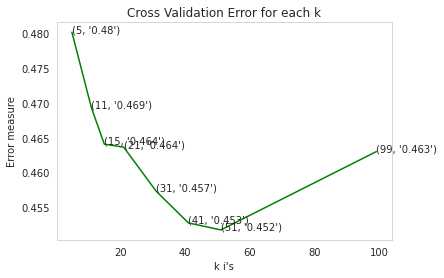

For values of best k =  51 The train log loss is: 0.4273043392960509
For values of best k =  51 The cross validation log loss is: 0.45176402052006404
For values of best k =  51 The test log loss is: 0.4352695302702697


In [ ]:
k = [5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error_array = []
for i in k:
    print("for k =", i)
    clf = KNeighborsClassifier(n_neighbors = i)
    clf.fit(train_data, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_data, y_train)
    sig_clf_probs = sig_clf.predict_proba(cv_data)
    cv_log_error_array.append(log_loss(y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(y_cv, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(k, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((k[i],str(txt)), (k[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each k")
plt.xlabel("k i's")
plt.ylabel("Error measure")
plt.show()


best_k = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=k[best_k])
clf.fit(train_data, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_data, y_train)

predict_y = sig_clf.predict_proba(train_data)
print('For values of best k = ', k[best_k], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_data)
print('For values of best k = ', k[best_k], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_data)
print('For values of best k = ', k[best_k], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


<h3> Making Predictions </h3>

Log loss : 0.4352695302702697
Percent of mis-classified points : 0.19480519480519481
-------------------- Confusion matrix --------------------


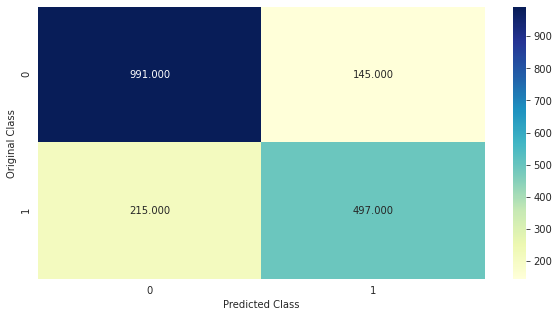

-------------------- Precision matrix  --------------------


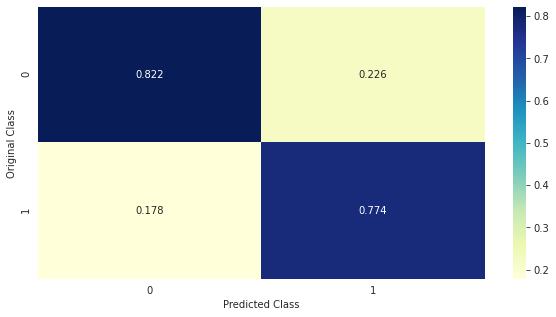

-------------------- Recall matrix --------------------


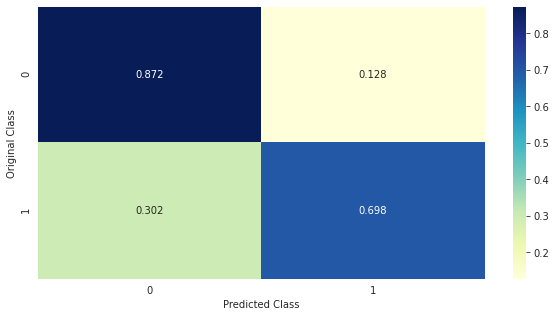

In [ ]:
clf = KNeighborsClassifier(n_neighbors=k[best_k])
predict_and_plot_confusion_matrix(train_data, y_train, test_data, y_test, clf)

<h2> K-NN on additional features </h2>

<h3> Hyper Prama Tuning </h3>

for k = 5
Log Loss : 0.44856571118557154
for k = 11
Log Loss : 0.4401974632729842
for k = 15
Log Loss : 0.43649681314848576
for k = 21
Log Loss : 0.43788535367873743
for k = 31
Log Loss : 0.43562303437183514
for k = 41
Log Loss : 0.43745081126689644
for k = 51
Log Loss : 0.4403108012960092
for k = 99
Log Loss : 0.4576172522200727


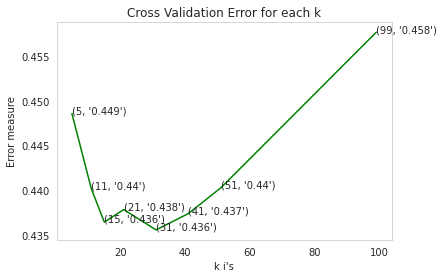

For values of best k =  31 The train log loss is: 0.40503666288922735
For values of best k =  31 The cross validation log loss is: 0.43562303437183514
For values of best k =  31 The test log loss is: 0.4229959080278024


In [ ]:
k = [5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error_array = []
for i in k:
    print("for k =", i)
    clf = KNeighborsClassifier(n_neighbors = i)
    clf.fit(train_occ_data, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_occ_data, y_train)
    sig_clf_probs = sig_clf.predict_proba(cv_occ_data)
    cv_log_error_array.append(log_loss(y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(y_cv, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(k, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((k[i],str(txt)), (k[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each k")
plt.xlabel("k i's")
plt.ylabel("Error measure")
plt.show()


best_k = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=k[best_k])
clf.fit(train_occ_data, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_occ_data, y_train)

predict_y = sig_clf.predict_proba(train_occ_data)
print('For values of best k = ', k[best_k], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_occ_data)
print('For values of best k = ', k[best_k], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_occ_data)
print('For values of best k = ', k[best_k], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


<h3> Making Predictions </h3>

Log loss : 0.4229959080278024
Percent of mis-classified points : 0.18614718614718614
-------------------- Confusion matrix --------------------


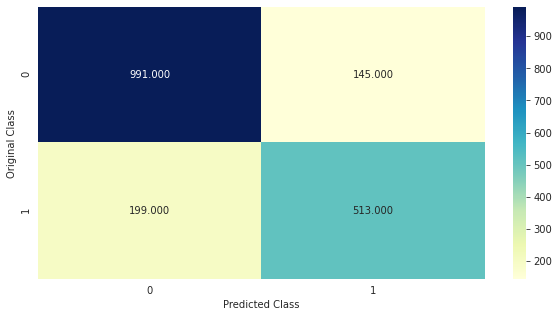

-------------------- Precision matrix  --------------------


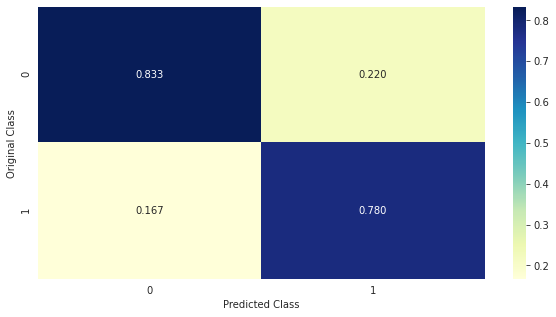

-------------------- Recall matrix --------------------


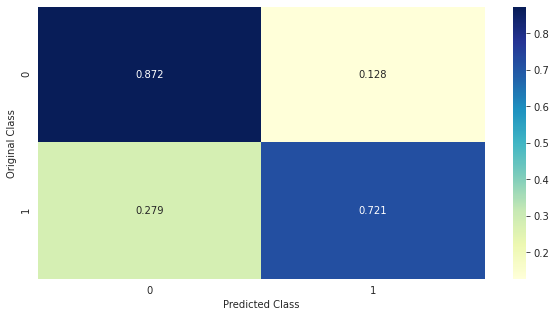

In [ ]:
clf = KNeighborsClassifier(n_neighbors=k[best_k])
predict_and_plot_confusion_matrix(train_occ_data, y_train, test_occ_data, y_test, clf)

<h1> Logistic Regression </h1>

<h2> On original Set of Features </h2>

<h3> Hyper Param Tuning </h3>

for alpha = 1e-06
Log Loss : 0.5115404579219502
for alpha = 1e-05
Log Loss : 0.47102679281663534
for alpha = 0.0001
Log Loss : 0.47255824203305025
for alpha = 0.001
Log Loss : 0.47338920835550663
for alpha = 0.01
Log Loss : 0.4874100794151575
for alpha = 0.1
Log Loss : 0.5399962398648117
for alpha = 1
Log Loss : 0.5709864279336826
for alpha = 10
Log Loss : 0.5785692740856128
for alpha = 100
Log Loss : 0.5795428552488745


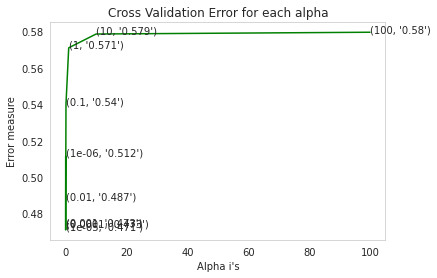

For values of best alpha =  1e-05 The train log loss is: 0.4515892944968643
For values of best alpha =  1e-05 The cross validation log loss is: 0.4730934553528538
For values of best alpha =  1e-05 The test log loss is: 0.45265144020032116


In [ ]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight = None, alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_data, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_data, y_train)
    sig_clf_probs = sig_clf.predict_proba(cv_data)
    cv_log_error_array.append(log_loss(y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(y_cv, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_data, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_data, y_train)

predict_y = sig_clf.predict_proba(train_data)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_data)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_data)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

<h3> Making Predictions </h3>

Log loss : 0.4512253573308823
Percent of mis-classified points : 0.2067099567099567
-------------------- Confusion matrix --------------------


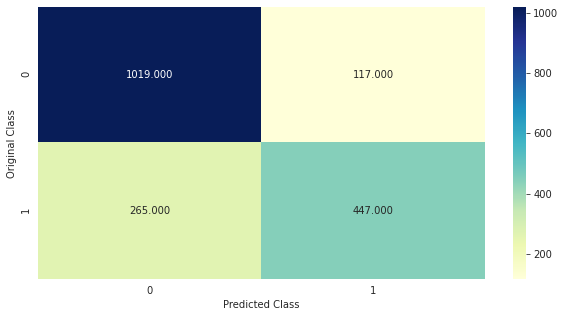

-------------------- Precision matrix  --------------------


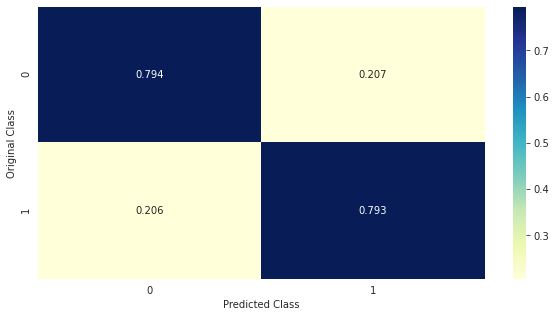

-------------------- Recall matrix --------------------


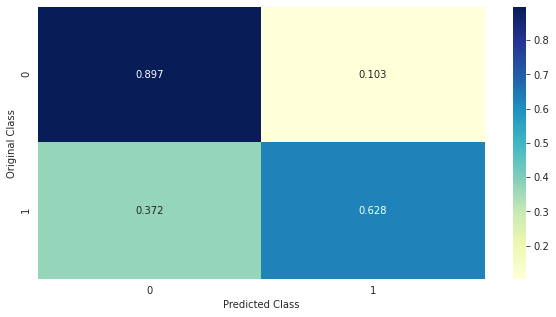

In [ ]:
clf = SGDClassifier(class_weight = None, alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_data, y_train, test_data, y_test, clf)

<h2> LR on additonal features </h2>

<h3> Hyper Param Tuning </h3>

for alpha = 1e-06
Log Loss : 0.47714155101676153
for alpha = 1e-05
Log Loss : 0.46769770924676507
for alpha = 0.0001
Log Loss : 0.46930947903045805
for alpha = 0.001
Log Loss : 0.47358180902239994
for alpha = 0.01
Log Loss : 0.4917463187980992
for alpha = 0.1
Log Loss : 0.5493842392683915
for alpha = 1
Log Loss : 0.5830020220888841
for alpha = 10
Log Loss : 0.612122867530379
for alpha = 100
Log Loss : 0.6201056913492896


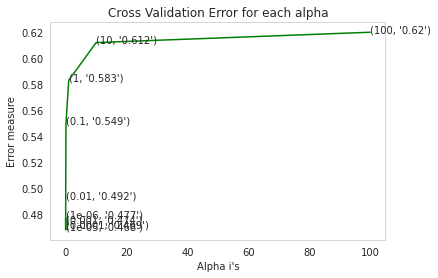

For values of best alpha =  1e-05 The train log loss is: 0.4400371791569454
For values of best alpha =  1e-05 The cross validation log loss is: 0.4668273936620567
For values of best alpha =  1e-05 The test log loss is: 0.4434621206515921


In [ ]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight = None, alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_occ_data, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_occ_data, y_train)
    sig_clf_probs = sig_clf.predict_proba(cv_occ_data)
    cv_log_error_array.append(log_loss(y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(y_cv, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_occ_data, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_occ_data, y_train)

predict_y = sig_clf.predict_proba(train_occ_data)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_occ_data)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_occ_data)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

<h3> Making Predictions </h3>

Log loss : 0.44282142784768674
Percent of mis-classified points : 0.2067099567099567
-------------------- Confusion matrix --------------------


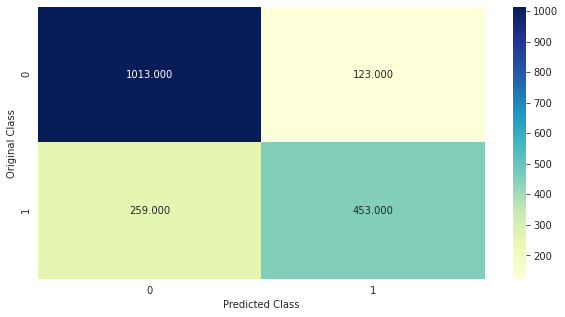

-------------------- Precision matrix  --------------------


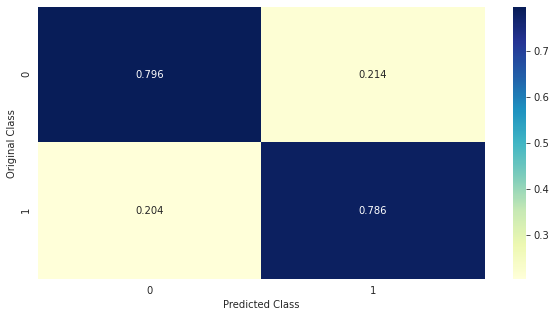

-------------------- Recall matrix --------------------


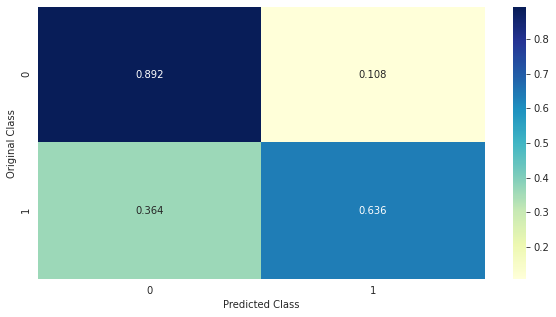

In [ ]:
clf = SGDClassifier(class_weight = None, alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_occ_data, y_train, test_occ_data, y_test, clf)

<h1> Random Forest </h1>

<h2> RF on original feature set </h2>

<h3> Hyper Param Tuning </h3>

In [ ]:
alpha = [100,200,500,1000,2000]
max_depth = [5, 10, 15, 25, 50, 75, 100]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_data, y_train)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_data, y_train)
        sig_clf_probs = sig_clf.predict_proba(cv_data)
        cv_log_error_array.append(log_loss(y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(y_cv, sig_clf_probs)) 


best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_data, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_data, y_train)

predict_y = sig_clf.predict_proba(train_data)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_data)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_data)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for n_estimators = 100 and max depth =  5
Log Loss : 0.4578735152791161
for n_estimators = 100 and max depth =  10
Log Loss : 0.4431101822983762
for n_estimators = 100 and max depth =  15
Log Loss : 0.451676637288253
for n_estimators = 100 and max depth =  25
Log Loss : 0.4828561786629598
for n_estimators = 100 and max depth =  50
Log Loss : 0.48945640053609957
for n_estimators = 100 and max depth =  75
Log Loss : 0.48945640053609957
for n_estimators = 100 and max depth =  100
Log Loss : 0.48945640053609957
for n_estimators = 200 and max depth =  5
Log Loss : 0.45837336215880536
for n_estimators = 200 and max depth =  10
Log Loss : 0.44335291639721297
for n_estimators = 200 and max depth =  15
Log Loss : 0.45260670352950344
for n_estimators = 200 and max depth =  25
Log Loss : 0.48250451084035023
for n_estimators = 200 and max depth =  50
Log Loss : 0.4882201966307969
for n_estimators = 200 and max depth =  75
Log Loss : 0.4882201966307969
for n_estimators = 200 and max depth =  100
Lo

<h3> Making Predictions </h3>

Log loss : 0.3993872892747833
Percent of mis-classified points : 0.18073593073593072
-------------------- Confusion matrix --------------------


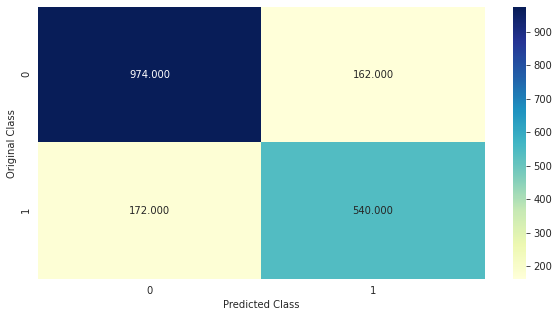

-------------------- Precision matrix  --------------------


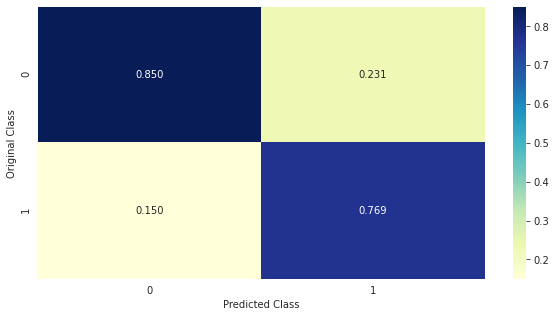

-------------------- Recall matrix --------------------


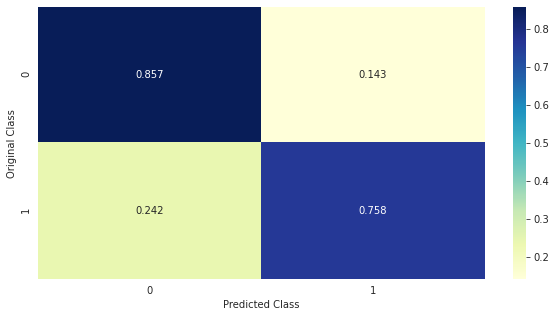

In [ ]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
predict_and_plot_confusion_matrix(train_data, y_train, test_data, y_test, clf)

<h2> RF on additional set of features </h2>

In [ ]:
alpha = [10, 50, 100, 200, 500, 1000]
max_depth = [5, 10, 15, 25, 50, 75, 100]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_occ_data, y_train)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_occ_data, y_train)
        sig_clf_probs = sig_clf.predict_proba(cv_occ_data)
        cv_log_error_array.append(log_loss(y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(y_cv, sig_clf_probs)) 


best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_occ_data, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_occ_data, y_train)

predict_y = sig_clf.predict_proba(train_occ_data)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_occ_data)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_occ_data)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for n_estimators = 10 and max depth =  5
Log Loss : 0.40863636391828173
for n_estimators = 10 and max depth =  10
Log Loss : 0.39372358989259226
for n_estimators = 10 and max depth =  15
Log Loss : 0.4033600633330698
for n_estimators = 10 and max depth =  25
Log Loss : 0.42298533253427445
for n_estimators = 10 and max depth =  50
Log Loss : 0.4277266623502585
for n_estimators = 10 and max depth =  75
Log Loss : 0.4277266623502585
for n_estimators = 10 and max depth =  100
Log Loss : 0.4277266623502585
for n_estimators = 50 and max depth =  5
Log Loss : 0.403665009551897
for n_estimators = 50 and max depth =  10
Log Loss : 0.39333013137797834
for n_estimators = 50 and max depth =  15
Log Loss : 0.40064566158560305
for n_estimators = 50 and max depth =  25
Log Loss : 0.4151843864939012
for n_estimators = 50 and max depth =  50
Log Loss : 0.41791270548035586
for n_estimators = 50 and max depth =  75
Log Loss : 0.41791270548035586
for n_estimators = 50 and max depth =  100
Log Loss : 0.417

IndexError: ignored

In [ ]:
cv_log_error_array

[0.40863636391828173,
 0.39372358989259226,
 0.4033600633330698,
 0.42298533253427445,
 0.4277266623502585,
 0.4277266623502585,
 0.4277266623502585,
 0.403665009551897,
 0.39333013137797834,
 0.40064566158560305,
 0.4151843864939012,
 0.41791270548035586,
 0.41791270548035586,
 0.41791270548035586,
 0.4032161797625808,
 0.39293651682518743,
 0.3994462165913838,
 0.41479420405510015,
 0.41626119266979694,
 0.41626119266979694,
 0.41626119266979694,
 0.4031558807959169,
 0.39221293090516457,
 0.39832272976054106,
 0.41480434894677837,
 0.4162592959866253,
 0.4162592959866253,
 0.4162592959866253,
 0.40463414758984156,
 0.39224282341206596,
 0.39803965150708726,
 0.4141626393501586,
 0.41544562266050666,
 0.41544562266050666,
 0.41544562266050666,
 0.4044368641879444,
 0.3923819436527735,
 0.39802034189515756,
 0.4138930279621731,
 0.41534165476691276,
 0.41534165476691276,
 0.41534165476691276]

In [ ]:
clf = RandomForestClassifier(n_estimators = 200, criterion='gini', max_depth= 10, random_state=42, n_jobs=-1)
clf.fit(train_occ_data, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_occ_data, y_train)

predict_y = sig_clf.predict_proba(train_occ_data)
print('For values of best estimator = ', 200, "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_occ_data)
print('For values of best estimator = ', 200, "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_occ_data)
print('For values of best estimator = ', 200, "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best estimator =  200 The train log loss is: 0.315266450106013
For values of best estimator =  200 The cross validation log loss is: 0.3922129309051646
For values of best estimator =  200 The test log loss is: 0.3815430783317528


<h3> Making Predictions </h3>

Log loss : 0.3815430783317528
Percent of mis-classified points : 0.16504329004329005
-------------------- Confusion matrix --------------------


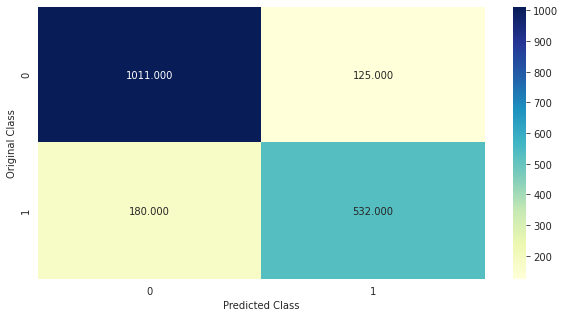

-------------------- Precision matrix  --------------------


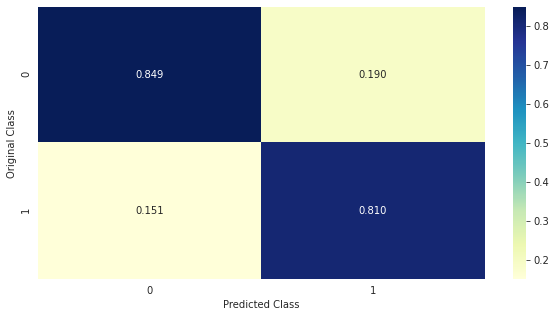

-------------------- Recall matrix --------------------


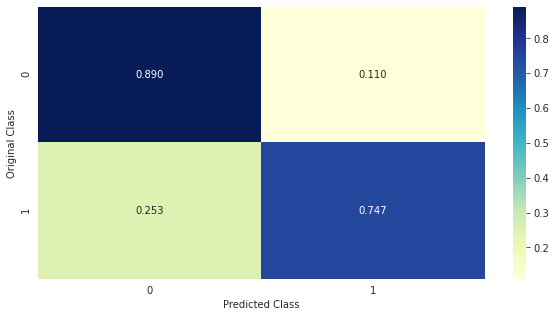

In [ ]:
clf = RandomForestClassifier(n_estimators = 200, criterion='gini', max_depth = 10, random_state=42, n_jobs=-1)
predict_and_plot_confusion_matrix(train_occ_data, y_train, test_occ_data, y_test, clf)

In [ ]:
def imp_features(data, features, keep, data_y):
  '''
  This function computes feature importance
  '''
  rf = RandomForestClassifier(n_estimators = 200, max_depth = 10)
  rf.fit(data, data_y)
  imp_feature_indx = np.argsort(rf.feature_importances_)[::-1]
  imp_value = np.take(rf.feature_importances_, imp_feature_indx[:20])
  imp_feature_name = np.take(features, imp_feature_indx[:20])
  sns.set()
  plt.figure(figsize = (10, 5))
  ax = sns.barplot(x = imp_feature_name, y = imp_value)
  ax.set_xticklabels(labels = imp_feature_name, rotation = 45)
  sns.set_palette(reversed(sns.color_palette("husl", 10)), 10)
  plt.title('Important Features')
  plt.xlabel('Feature Names')
  plt.ylabel('Importance')

  return imp_feature_indx[:keep]

In [ ]:
#Generating feature names
feature_names = origin_vectorizer.get_feature_names() + source_vectorizer.get_feature_names() + lst_activ_vectorizer.get_feature_names() + spec_vectorizer.get_feature_names() +curr_occ_vectorizer.get_feature_names() + notable_activ_vectorizer.get_feature_names() + ['TotalVisits', 'Total Time Spent on Website', 'Page Views Per Visit'] + list(train_occr_df.columns) + ['Do Not Email', 'A free copy of Mastering The Interview']

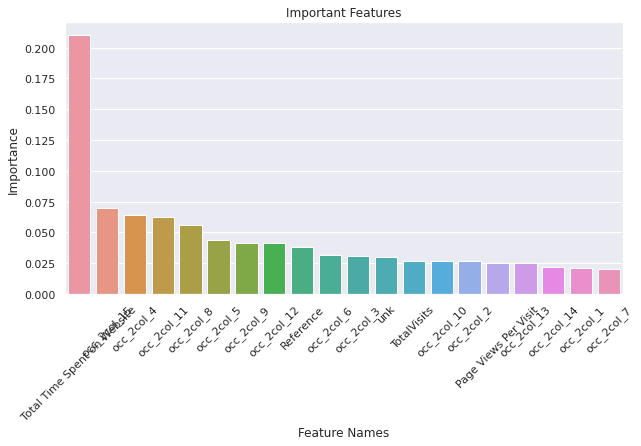

In [ ]:
#Plotting top features with score
top_features_index = imp_features(train_occ_data, feature_names, 50, y_train)

**As stated on EDA Total Time Spend is the most important feature with high score, other important features are the one that were created, occurence features are also important and adding these features have reduced the log loss...**

In [ ]:
print('Top 20 features in the descending order of importance are: {}'.format(np.take(feature_names, top_features_index[:20])))

Top 20 features in the descending order of importance are: ['Total Time Spent on Website' 'occ_2col_15' 'occ_2col_4' 'occ_2col_11'
 'occ_2col_8' 'occ_2col_5' 'occ_2col_9' 'occ_2col_12' 'Reference'
 'occ_2col_6' 'occ_2col_3' 'unk' 'TotalVisits' 'occ_2col_10' 'occ_2col_2'
 'Page Views Per Visit' 'occ_2col_13' 'occ_2col_14' 'occ_2col_1'
 'occ_2col_7']


<h1> XGB </h1>

**For XGB, instead of tuning param manually using Randomized Search CV for this task**


In [ ]:
x_clf = XGBClassifier()
prams={
'learning_rate': [0.01,0.03,0.05,0.1,0.15,0.2],
'n_estimators': [100,200,500,1000,2000],
'max_depth': [3,5,10],
'colsample_bytree': [0.1,0.3,0.5,1],
'subsample': [0.1,0.3,0.5,1]
}
random_clf = RandomizedSearchCV(x_clf, param_distributions = prams, verbose=10)
random_clf.fit(train_occ_data , y_train)
print (random_clf.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] subsample=0.3, n_estimators=100, max_depth=10, learning_rate=0.15, colsample_bytree=0.1 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  subsample=0.3, n_estimators=100, max_depth=10, learning_rate=0.15, colsample_bytree=0.1, score=0.837, total=   0.7s
[CV] subsample=0.3, n_estimators=100, max_depth=10, learning_rate=0.15, colsample_bytree=0.1 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV]  subsample=0.3, n_estimators=100, max_depth=10, learning_rate=0.15, colsample_bytree=0.1, score=0.823, total=   0.5s
[CV] subsample=0.3, n_estimators=100, max_depth=10, learning_rate=0.15, colsample_bytree=0.1 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s remaining:    0.0s


[CV]  subsample=0.3, n_estimators=100, max_depth=10, learning_rate=0.15, colsample_bytree=0.1, score=0.811, total=   0.5s
[CV] subsample=0.3, n_estimators=100, max_depth=10, learning_rate=0.15, colsample_bytree=0.1 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.7s remaining:    0.0s


[CV]  subsample=0.3, n_estimators=100, max_depth=10, learning_rate=0.15, colsample_bytree=0.1, score=0.837, total=   0.5s
[CV] subsample=0.3, n_estimators=100, max_depth=10, learning_rate=0.15, colsample_bytree=0.1 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    2.2s remaining:    0.0s


[CV]  subsample=0.3, n_estimators=100, max_depth=10, learning_rate=0.15, colsample_bytree=0.1, score=0.828, total=   0.5s
[CV] subsample=0.1, n_estimators=100, max_depth=5, learning_rate=0.1, colsample_bytree=0.3 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.7s remaining:    0.0s


[CV]  subsample=0.1, n_estimators=100, max_depth=5, learning_rate=0.1, colsample_bytree=0.3, score=0.845, total=   0.4s
[CV] subsample=0.1, n_estimators=100, max_depth=5, learning_rate=0.1, colsample_bytree=0.3 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    3.2s remaining:    0.0s


[CV]  subsample=0.1, n_estimators=100, max_depth=5, learning_rate=0.1, colsample_bytree=0.3, score=0.820, total=   0.4s
[CV] subsample=0.1, n_estimators=100, max_depth=5, learning_rate=0.1, colsample_bytree=0.3 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    3.6s remaining:    0.0s


[CV]  subsample=0.1, n_estimators=100, max_depth=5, learning_rate=0.1, colsample_bytree=0.3, score=0.823, total=   0.4s
[CV] subsample=0.1, n_estimators=100, max_depth=5, learning_rate=0.1, colsample_bytree=0.3 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    4.1s remaining:    0.0s


[CV]  subsample=0.1, n_estimators=100, max_depth=5, learning_rate=0.1, colsample_bytree=0.3, score=0.841, total=   0.5s
[CV] subsample=0.1, n_estimators=100, max_depth=5, learning_rate=0.1, colsample_bytree=0.3 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    4.5s remaining:    0.0s


[CV]  subsample=0.1, n_estimators=100, max_depth=5, learning_rate=0.1, colsample_bytree=0.3, score=0.818, total=   0.4s
[CV] subsample=1, n_estimators=500, max_depth=10, learning_rate=0.15, colsample_bytree=0.1 
[CV]  subsample=1, n_estimators=500, max_depth=10, learning_rate=0.15, colsample_bytree=0.1, score=0.825, total=   2.1s
[CV] subsample=1, n_estimators=500, max_depth=10, learning_rate=0.15, colsample_bytree=0.1 
[CV]  subsample=1, n_estimators=500, max_depth=10, learning_rate=0.15, colsample_bytree=0.1, score=0.809, total=   2.1s
[CV] subsample=1, n_estimators=500, max_depth=10, learning_rate=0.15, colsample_bytree=0.1 
[CV]  subsample=1, n_estimators=500, max_depth=10, learning_rate=0.15, colsample_bytree=0.1, score=0.806, total=   2.1s
[CV] subsample=1, n_estimators=500, max_depth=10, learning_rate=0.15, colsample_bytree=0.1 
[CV]  subsample=1, n_estimators=500, max_depth=10, learning_rate=0.15, colsample_bytree=0.1, score=0.838, total=   2.1s
[CV] subsample=1, n_estimators=5

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  2.9min finished


{'subsample': 0.3, 'n_estimators': 1000, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 0.3}


<h3> Making Predictions </h3>

In [ ]:
x_clf = XGBClassifier(n_estimators = 1000, learning_rate = 0.01, colsample_bytree = .3, max_depth = 3, subsample = .3)
x_clf.fit(train_occ_data, y_train)
c_clf = CalibratedClassifierCV(x_clf, method='sigmoid')
c_clf.fit(train_occ_data, y_train)
predict_y = c_clf.predict_proba(train_occ_data)
print ('train loss',log_loss(y_train, predict_y))
predict_y = c_clf.predict_proba(cv_occ_data)
print ('cv loss',log_loss(y_cv, predict_y))
predict_y = c_clf.predict_proba(test_occ_data)
print ('test loss',log_loss(y_test, predict_y))

train loss 0.35723535117545907
cv loss 0.3894370679767807
test loss 0.380564682209099


Log loss : 0.380564682209099
Percent of mis-classified points : 0.16504329004329005
-------------------- Confusion matrix --------------------


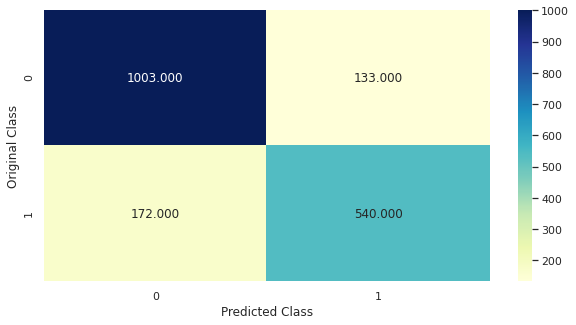

-------------------- Precision matrix  --------------------


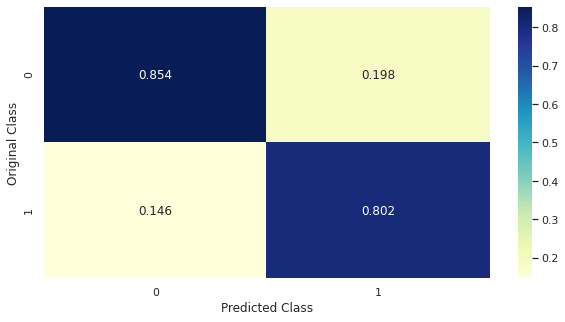

-------------------- Recall matrix --------------------


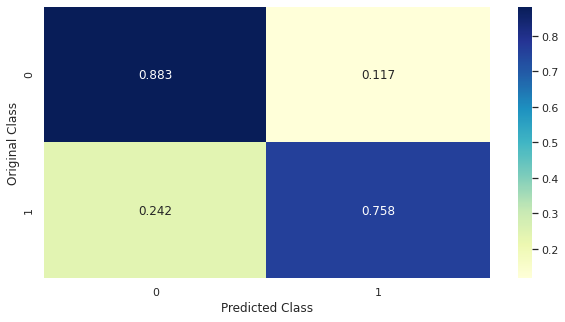

In [ ]:
clf = XGBClassifier(n_estimators = 1000, learning_rate = 0.01, colsample_bytree = .3, max_depth = 3, subsample = .3)
predict_and_plot_confusion_matrix(train_occ_data, y_train, test_occ_data, y_test, clf)

#Conclusion

In [ ]:
x = PrettyTable()
x.field_names = ["Model", "Train Log Loss", "CV Log Loss", "Test Log Loss", "%age Misclassification"]
x.add_row(["Random Model", 'NA', .883, .902, 'NA'])
x.add_row(["KNN", .427, .451, .435, 19.5])
x.add_row(["KNN + new features", .405, .435, .423, 18.6])
x.add_row(["LR", .451, .473, .452, 20.67])
x.add_row(["LR + New Features", .44, .466, .443, 20.67])
x.add_row(["RF", .377, .443, .399, 18])
x.add_row(["RF + New Features", .315, .392, 0.381, 16.5])
x.add_row(["XGB + New Features", .357, .389, .380, 16.5])
print(x)

+--------------------+----------------+-------------+---------------+------------------------+
|       Model        | Train Log Loss | CV Log Loss | Test Log Loss | %age Misclassification |
+--------------------+----------------+-------------+---------------+------------------------+
|    Random Model    |       NA       |    0.883    |     0.902     |           NA           |
|        KNN         |     0.427      |    0.451    |     0.435     |          19.5          |
| KNN + new features |     0.405      |    0.435    |     0.423     |          18.6          |
|         LR         |     0.451      |    0.473    |     0.452     |         20.67          |
| LR + New Features  |      0.44      |    0.466    |     0.443     |         20.67          |
|         RF         |     0.377      |    0.443    |     0.399     |           18           |
| RF + New Features  |     0.315      |    0.392    |     0.381     |          16.5          |
| XGB + New Features |     0.357      |    0.389  

#Assignment Questions

1. **How long did it take you to solve the problem ?** Have given some 12 hours to this problem.
2. **What software language and libraries did you use to solve the problem?** This notebook is written in Python3, major libraries used are: pandas, numpy, sklearn, scipy, seaborn, matplotlib.
3. **What steps did you take to prepare the data for this project ? Was any cleaning necessary ?** Maximum time was spent on data preparation. It started with basic data cleaning steps, it was required to clean the data as not every piece of information is value to the models, this data had lot of columns that were not a value add to the model. Also, we had lot of missing values, columns with missing values were either imputed or dropped completely. This notebook has detail of every decision being taken. Also, once data cleaning and EDA was done, data was converted into the desired format for the machine to understand and additonal features were also created.
4. **What algorithmic method did you apply? Why? What other methods did you consider?** While working on any ML problem , we should not just stick with one algo, rather than try various techniques to see which one works better for our problem statement. For this problem tried K-NN, Logistic Regression, Random Forest and XGBoost. Why only these? These algorithms covers different aspects, K-NN being non paramteric and is distance based, Logistice Regression being parametric, RF and XGB using the idea of information theory to give us the best split. One thing to notice is that all these algorithm have variance in general(even XGB). Algo like Naive Bayes that work on prior knowledge adds some additional bias and since we made some assumptions already about our data during cleaning phase, such algorithms were avoided. So, algo were majorly chosen keeping in mind the bias-variance trade-off.
5. **What features did you use? Why?** Features were chosen after cleaning the data, we tried 2 set of features, first set had features left out after data cleaning and 2nd set were the features that were created by understanding the interaction of categorical features. Features were chosen after understanding the data properly during EDA. All the 11 raw features were important as per our EDA and so these were part of the final feature list.
6. **How did you train your model? During training, what issues concerned you?**  Before training the model, data was divided into 3 set: train, test and cv. Model was trained on train set, hyper param were tuned on cv and results were computed on test. While training the major concern is the data leakage issue, we should never have data leakeage issue or else our model won't generalize properly. Another concern was hyper param tuning. Also, we were dealing in probabilities(final outcome), major concern was the probability distribution generated by our models, which is not same to actual, hence calibration was used.
7. **How did you assess the accuracy of your predictions? Why did you choose that method? Would you consider any alternative approaches for assessing accuracy?** For this project log loss was the metric that was considered. It was considered based on the business requirement. Since we were interested in the score from 0 to 100 instead of the actual labels, it did made sense to consider probabilities. When we have probabilities, it is always good to have log loss as the metric as it penalizes with slight deviation. So we were trying to minimize log loss in this case. Log Loss has an issue which is interpretibility, so we should either have a baseline score(like we had in this case), or we can have a some other metric to support our results, like we did in this case, we considered confusion matrix, recall matrix & precision matrix. These matrix along with log loss gives good indication of our solutions. One point to note over here is that log loss can be used to compare performance between models like we did, but these matrix should only be used to interpret, they can't/should not be used to compare different models.
8. **Which features had the greatest impact? How did you identify these to be most significant?**  In this solution notebook, we already have the top 20 features printed, Total Time Spent on Website was the top feature along with newly created occurence features. Feature Importance was done using the RF feature_importance.

#Future Scope

1. This solution can be considered as a first cut solution, and we should try to improve the results.
2. We did print the top 20 features out of 103 considered features, we can try with top k features and see if our model performance is increasing.
3. Adding more features based on interaction between variables can further improve our KPI.
4. Revisit data cleaning steps to see if we have not missed anything,also if we have some domain person with us, we can sit to undertand the imputation part and accordingly make changes to our imputation techniques(this will again add bias).
5. Making this code ready for production and planning on how to deply this.